<a href="https://colab.research.google.com/github/sallyhu-seas/NYC-airbnb/blob/main/Airbnbs_What_Makes_Them_Successful%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to our City!

You're planning a trip to New York City and Los Angeles, and you're looking for places to stay, but you're not sure where to begin. You might have a specific budget, you might want to walk everywhere, you might need robust WiFi, who knows! Only you do.

You peruse the Internet a little longer and, there it is: the two most perfect Airbnbs, one in each city. The prices are perfect, the locations are perfect, and one even has a hot tub and the other has a stunning rooftop view! Booked.

How did the hosts of your chosen Airbnbs know what you wanted? There's no way every visitor has the same needs as you, but the Airbnbs seemed perfect and had really high ratings!

In this project, we will analyze and assess the factors, both quantitative and qualitative, that make Airbnbs in NYC and LA successful. The analysis will center around two central themes:


*   ***Internal factors***: What makes an Airbnb appealing based on the listing? What can a host say or post that would a visitor more inclined to choose their Airbnb? Is it the amenities? How about the description of the listing? Maybe they need to respond to requests faster?
*   ***External factors***: We specifically chose NYC and LA because these vibrant cities are popular destinations for vistors of all backgrounds and they are diverse in every sense of the word: socioeconomically, demographically, culturally, etc. Consequently, we will analyze the impact of the city itself on the success of Airbnbs.


After analyzing the impact of these factors and more, we will predict the price and success of future listings, and recommend measures hosts can take to attract more guests (like you!).

# Data Exploration and Preprocessing

First, we pinpointed the data that are relevant to our analysis. Each dataset came from the following sources:


*   **Main Airbnb Listings Dataset: [Inside Airbnb](http://insideairbnb.com/get-the-data.html)**
      * Listings: Contains all attributes associated with a given Airbnb listing in NYC and LA since 2008.
*   **NYC Crime Data: [NYC OpenData](https://data.cityofnewyork.us/Public-Safety/NYC-crime/qb7u-rbmr)**
      * NYPD Complaint Data: Contains all valid felony, misdemeanor, and violation crimes reported to the NYC Police Department (NYPD) since 2017.
*   **LA Crime Data: [Los Angeles Times](http://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/)**
      * LA Times Violent Crimes Data: Contains a breakdown of violent crimes per capita in each neighborhood in LA since end of 2019.
*   **NYC Income Data: [Citizens' Committee for Children](https://data.cccnewyork.org/data/download#0,8/66)**
      * Income-Level Data: Contains NYC household median income data by neighborhood since 1900. This data is filtered to keep only data from 2010 and after.
*   **LA Income Data: [Los Angeles County Open Data](https://geohub.lacity.org/datasets/lacounty::median-household-income-by-census-tract) and [USC Price Center for Social Innovation](https://usc.data.socrata.com/Los-Angeles/Census-Tract-Locations-LA-/atat-mmad)**
      * LA County Income-Level Data: Contains 2018 LA median income data by census tract.
      * USC Census Tract Locations: Contains a mapping between census tracts and neighborhoods in LA.


We will explore and preprocess each dataset in this section.

In [ ]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26818 sha256=d681f4a51339d04050eb9c5cfeba86a2015a7ab38ac32ebc98fbd0e4f1050642
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps

import zipfile
from google.colab import drive

import re
import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, names, words
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
nltk.download('words')
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import geopy
from geopy.exc import GeocoderTimedOut

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import torch
from torch import nn, optim
import torch.nn.functional as F 
import torch.utils.data as data

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile('/content/drive/Shared drives/CIS545: AirBnB/inside_airbnb.zip','r')
zip_ref.extractall('/content/sample_data')

Mounted at /content/drive/


## NYC and LA Airbnb Listings

### First Glance
The listings data provides us with so many attributes related to a given Airbnb listing in NYC and LA. First, we'll load the data from both cities and combine them.

In [ ]:
listings_nyc_df = pd.read_csv('/content/sample_data/Inside Airbnb/listings.csv')
listings_la_df = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listings_la.csv')

In [ ]:
# Merge both cities into one dataset
listings_df = ps.sqldf('''
                        SELECT  *, 'NYC' as city
                        FROM    listings_nyc_df
                        UNION
                        SELECT  *, 'LA' as city
                        FROM    listings_la_df
                      ''')

In [ ]:
listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
0,109,https://www.airbnb.com/rooms/109,2.020100e+13,10/25/2020,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,6/27/2008,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",None,None,0%,f,https://a0.muscache.com/im/pictures/user/e704a...,https://a0.muscache.com/im/pictures/user/e704a...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,None,Culver City,Other Cities,33.98209,-118.38494,Entire condominium,Entire home/apt,6,None,2 baths,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,None,t,0,0,0,207,10/25/2020,2,0,0,8/15/2011,5/15/2016,80.0,10.0,10.0,6.0,8.0,10.0,8.0,None,f,1,1,0,0,0.02,LA
1,2595,https://www.airbnb.com/rooms/2595,2.020100e+13,10/7/2020,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,9/9/2008,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75362,-73.98377,Entire apartment,Entire home/apt,2,None,1 bath,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",$175.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,None,t,30,60,90,365,10/7/2020,48,1,0,11/21/2009,11/4/2019,94.0,9.0,9.0,10.0,10.0,10.0,9.0,None,f,2,2,0,0,0.36,NYC
2,2708,https://www.airbnb.com/rooms/2708,2.020100e+13,10/10/2020,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,Chas.,9/16/2008,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Los Angeles, California, United States",Hollywood,City of Los Angeles,34.09768,-118.34602,Private room in apartment,Private room,1,None,1.5 baths,1.0,1.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",$75.00,30,366,30.0,30.0,1125.0,1125.

The data generally looks good, but we're not sure if it actually is. We want to take a full look at what is actually stored in this dataframe and what we might consider dropping.

At first glance, we already know certain columns must be preprocessed. For instance, we know from above that host_since is a date and host_response_rate is a percentage, but their types don't reflect that. Certainly price must be a number!

We also noticed that some columns are completely empty, like bathrooms and calendar_updated. These null columns can definitely be dropped. 

In [ ]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75199 entries, 0 to 75198
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            75199 non-null  int64  
 1   listing_url                                   75199 non-null  object 
 2   scrape_id                                     75199 non-null  float64
 3   last_scraped                                  75199 non-null  object 
 4   name                                          75181 non-null  object 
 5   description                                   72911 non-null  object 
 6   neighborhood_overview                         48167 non-null  object 
 7   picture_url                                   75199 non-null  object 
 8   host_id                                       75199 non-null  int64  
 9   host_url                                      75199 non-null 

### Basic Formatting
Before we begin exploring, we need to preprocess the most important parts of our data so that our exploration is meaningful. Our data must reflect the correct datatypes before we do anything else.

Judging from our initial look, these five columns should be dates. Let's update the type.

In [ ]:
listings_df['host_since']=listings_df['host_since'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['first_review']=listings_df['first_review'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['last_review']=listings_df['last_review'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['last_scraped']=listings_df['last_scraped'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['calendar_last_scraped']=listings_df['calendar_last_scraped'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))

These columns should also be float types so let's cast them as such.

In [ ]:
listings_df['price']=listings_df['price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))

In [ ]:
listings_df['host_response_rate']=listings_df['host_response_rate'].apply(lambda x: str(x).replace('%','') if isinstance(x,str) else 'None')
listings_df['host_acceptance_rate']=listings_df['host_acceptance_rate'].apply(lambda x: str(x).replace('%','') if isinstance(x,str) else 'None')

In [ ]:
def clean_pct(s):
  '''
  Convert percentage in string format to float
  '''
  if s=='None':
    return np.nan
  else:
    return float(s.strip('%'))/100

listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(lambda x: clean_pct(x))
listings_df['host_acceptance_rate']=listings_df['host_acceptance_rate'].apply(lambda x: clean_pct(x))

The listings data is officially ready to be explored. Let's take a look and see what we have. After our initial exploration, we'll finish preparing our dataset.

### Let's Explore!

Now we're going to poke around to learn about the data and also see if there's anything particularly striking. Our aim in this step is to find out what might be useful in our analysis and for our models, but also what can be thrown away.

This is our main dataset, so we explored and vetted it as thoroughly as possible.

#### **What to do with these?**

We'll take a closer look at the data and determine what is and isn't important to *our* analysis. During our exploration, we realized that a lot of attributes are interesting, but may not be necessarily relevant for our purposes. 

Note: Any and all final formatting efforts will be done in the [Final Cleaning and Formatting](#final-cleaning) section.

##### *Null Host Names?*

First, we noticed that there are 27 host names that are missing. After looking at the data, we saw that a lot of other information important to our analysis, such as ratings, are also null. Since there are so few, we concluded that we can drop these without impacting our analysis.

In [ ]:
listings_df[listings_df['host_name'].isna() == True]['id'].count()

27

In [ ]:
# Take a peek at the 27
listings_df[listings_df['host_name'].isna() == True]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
7247,4446862,https://www.airbnb.com/rooms/4446862,2.020100e+13,2020-10-06,Charming Room in Prospect Heights!,Quiet room in three bedroom apt in Prospect He...,This charming Brooklyn neighborhood offers man...,https://a0.muscache.com/pictures/57579076/ace3...,23077718,https://www.airbnb.com/users/show/23077718,None,NaT,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,"Brooklyn, New York, United States",Crown Heights,Brooklyn,40.67512,-73.96146,Private room in apartment,Private room,2,None,1 bath,1.0,1.0,"[""Essentials"", ""Heating"", ""Air conditioning"", ...",50.0,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,None,t,0,0,0,0,2020-10-06,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN,NYC
7808,4763327,https://www.airbnb.com/rooms/4763327,2.020100e+13,2020-10-06,"Luxurious, best location, spa inc'l","Brand new luxurious boutique building, swimmin...","Quoting from Time Out Magazine: ""Williamsburg ...",https://a0.muscache.com/pictures/59917673/e733...,24576978,https://www.airbnb.com/users/show/24576978,None,NaT,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,"Brooklyn, New York, United States",Greenpoint,Brooklyn,40.72035,-73.95355,Entire apartment,Entire home/apt,4,None,1 bath,1.0,2.0,"[""Pool"", ""Cable TV"", ""Essentials"", ""Washer"", ""...",195.0,1,1125,1.0,2.0,1125.0,1125.0,1.0,1125.0,None,t,0,0,0,0,2020-10-06,1,0,0,2015-10-20,2015-10-20,80.0,8.0,10.0,10.0,8.0,10.0,8.0,None,f,1,1,0,0,0.02,NYC
9816,6360224,https://www.airbnb.com/rooms/6360224,2.020100e+13,2020-10-10,"Sunny, Private room in Bushwick","Spacious room, lots of light. New, clean build...",None,https://a0.muscache.com/pictures/87714659/5b7b...,33134899,https://www.airbnb.com/users/show/33134899,None,NaT,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,Bushwick,Brooklyn,40.70146,-73.92792,Private room in apartment,Private room,1,None,0 baths,1.0,1.0,"[""Carbon monoxide alarm"", ""Air conditioning"", ...",37.0,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,None,t,0,0,0,0,2020-10-10,1,0,0,2015-07-01,2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,0.02,NYC
10680,6900415,https://www.airbnb.com/rooms/6900415,2.020100e+13,2020-10-10,"Quiet, Cozy West LA House","A beautiful, quiet little house with a great b...",Walking distance to coffee shops and restauran...,https://a0.muscache.com/pictures/87362346/ebd8...,36159573,https://www.airbnb.com/users/show/36159573,None,NaT,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,"Los Angeles, California, United States",Mar Vista,City of Los Angeles,34.00105,-118.43665,Entire house,Entire home/apt,3,None,1 bath,1.0,2.0,"[""Essentials"", ""Wifi"", ""Washer"", 

##### *'Host Listings Count' vs 'Host Total Listings Count'*

Looking at host_listings_count and host_total_listings_count, we figured these columns would be useful for our model. But what's the difference between the two? After checking, we confirmed that there are no differences between the two, so we will drop host_total_listings_count.

In [ ]:
listings_df[listings_df['host_listings_count'] != listings_df['host_total_listings_count']].dropna()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city


Now we'll take a look at what our data actually consists of.

#### **A Glance at All Airbnbs**

Here, we take a look at what Airbnbs look like in general.

##### *Time Frame*

Since we're going to be integrating our listings data with other sources, we need to see what time period we're working with.

In [ ]:
listings_df['year'] = listings_df['host_since'].apply(lambda x: x.year)
time_period=listings_df.groupby(['city','year']).count()
time_period.reset_index(inplace=True)

Airbnb was founded in August of 2008, so it makes sense that hosts began joining starting in 2008. However, it's very apparent that Airbnb really gained traction starting in 2010, which means that from that year on, guests will have many, many more options to choose from.

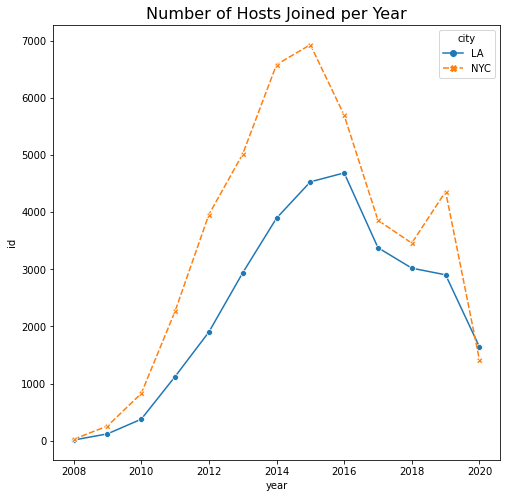

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(data=time_period, x='year', y='id', hue='city', markers=True, style='city',ci=None)
plt.title('Number of Hosts Joined per Year', fontsize=16)
plt.show()

##### *Verified Hosts*

Surely all hosts should be verified? Looking at the numbers, it would appear not! More than 20% of all hosts across both cities are not verified. We wonder if this impacts people's decisions to stay at an Airbnb or not.

In [ ]:
ps.sqldf(
    '''
      WITH totals AS (
        SELECT  city
                ,count(id) AS total
        FROM    listings_df
        GROUP BY city
      )
      SELECT  l.city
              ,host_identity_verified
              ,count(id) as numVerified
              ,CAST(count(id) AS FLOAT) / CAST(total AS FLOAT) * 100 AS percentVerified
      FROM    listings_df l
              INNER JOIN totals t ON l.city = t.city
      GROUP BY l.city, host_identity_verified
    '''
)

,city,host_identity_verified,numVerified,percentVerified
0,LA,None,10,0.032751
1,LA,f,6117,20.034062
2,LA,t,24406,79.933187
3,NYC,None,17,0.038060
4,NYC,f,9914,22.195854
5,NYC,t,34735,77.766086


##### *Number of Bedrooms*

Logically, we know that price and bedrooms are positively correlated, but let's take a look at the ranges. We'll focus on just listings with 5 or fewer bedrooms since they make up about 90% of all listings.

In [ ]:
listings_df[listings_df.bedrooms <=5]['id'].count()/listings_df['id'].count()

0.8920730328860756

What's interesting is that yes, prices do increase as the number of bedrooms increase but variance does too, especially once we get up to listings with 4 and 5 bedrooms. It will be interesting to see if this variance might impact our models. (We are not including outliers in the following visualizations to focus on a more general trend.)

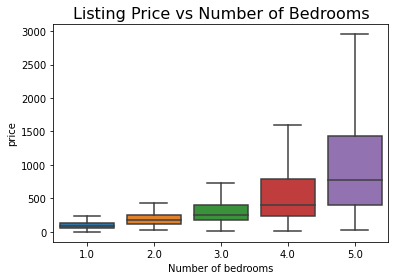

In [ ]:
sns.boxplot(data = listings_df[listings_df.bedrooms<=5], x='bedrooms', y='price', showfliers=False)
plt.xlabel('Number of bedrooms')
plt.title('Listing Price vs Number of Bedrooms', fontsize=16)
plt.show()

##### *Room Types*

Similarly, we want to know what the relationship between price and room types is like. How are hotels priced?

Understandably, the range of prices for hotels is extremely wide. 

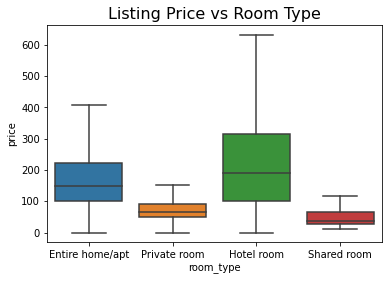

In [ ]:
sns.boxplot(data = listings_df, x='room_type', y='price', showfliers=False)
plt.title('Listing Price vs Room Type', fontsize=16)
plt.show()

#### **Comparisons by City**

We now want to get a sense of what Airbnbs in each city look like compared to each other.

For comparisons of counts, the data is first standardized since we have more NYC data (approx. 45k listings) compared to LA data (approx. 30k listings).

##### *Neighborhoods*

Here, we look at the spread of prices across neighborhood "groups" in each city. As expected, not a lot can be inferred from the LA "groups". With more than 200 neighborhoods in the city condensed into three groups, we would expect that the spread is about the same, with the actual city of Los Angeles being more expensive. We also note that the categorization in LA is very general, and might not provide much significant information.

The groups in NYC are more telling though because they correspond with each borough. Typically, Manhattan and Brooklyn are more popular but also bigger, so the spread matches our expectations.

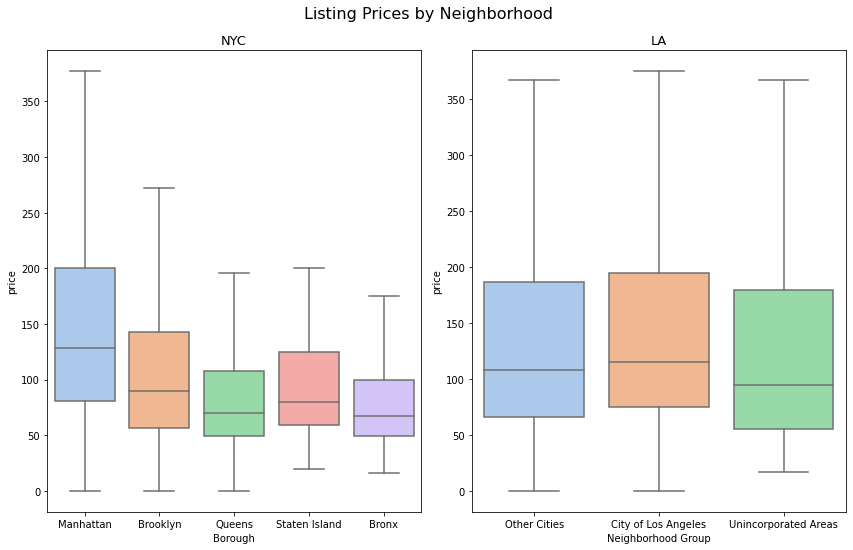

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
sns.boxplot(data=listings_df[listings_df.city=='NYC'], x='neighbourhood_group_cleansed', y='price', palette='pastel',showfliers=False,ax=ax[0])
sns.boxplot(data=listings_df[listings_df.city=='LA'], x='neighbourhood_group_cleansed', y='price', palette='pastel',showfliers=False,ax=ax[1])
fig.suptitle('Listing Prices by Neighborhood',fontsize=16)
ax[0].set_title('NYC', fontsize=13)
ax[0].set_xlabel('Borough')
ax[1].set_title('LA', fontsize=13)
ax[1].set_xlabel('Neighborhood Group')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

##### *Room Types*

What are the most popular types of Airbnbs? Given the differences in cost of living and layout of each city, we can expect that there will be some differences.

In [ ]:
# First, we standardize.
room_type = listings_df.groupby(['city', 'room_type']).agg({'id': 'count'})
room_type = room_type.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
room_type.reset_index(inplace=True)

After plotting the proportions, we can see that the types of Airbnbs in each city are quite different from one another. While entire homes/apartments and private rooms are the most popular in both cities, a big majority of Airbnbs in LA are entire homes/apartments while in NYC, the types are more evenly split between entire homes/apartments and private rooms. 

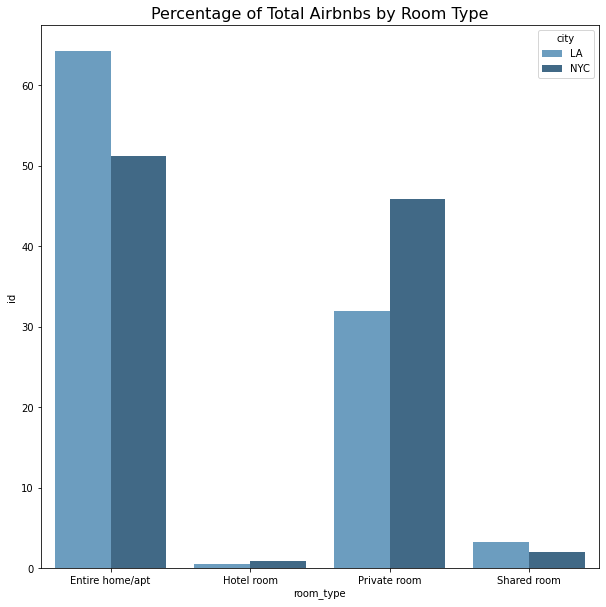

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='room_type', y='id', hue='city', data=room_type, palette='Blues_d')
plt.title('Percentage of Total Airbnbs by Room Type',fontsize=16)
plt.show()

##### *Host Response Times*

Do "West Coast vs East Coast" stereotypes hold? The belief is that West Coasters are generally more relaxed while East Coasters are more hurried. Do host response times reflect this stereotype? 

In [ ]:
# First, we standardize.
host_response_time = listings_df.groupby(['city', 'host_response_time']).agg({'id': 'count'})
host_response_time = host_response_time.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
host_response_time.reset_index(inplace=True)

It would appear not, but this is up to interpretation and speculation! We could assume that since West Coasters are more relaxed, they would respond to requests slower than their counterparts on the East Coast; however, this is clearly not the case since a big majority of them respond within an hour.

Another argument can be made that because West Coasters are so relaxed, they might have more time to attend to their personal affairs. Hopefully we can shed some light on this.

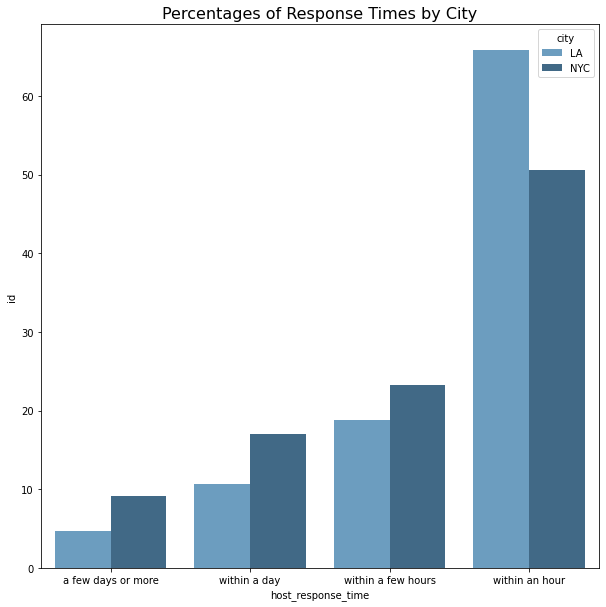

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='host_response_time', y='id', hue='city', data=host_response_time, palette='Blues_d')
plt.title('Percentages of Response Times by City',fontsize=16)
plt.show()

##### *Ratings from Reviews*

How do ratings stack up between the two cities? While ratings are generally high, which city comes out on top?

We'll take a look at the spread of ratings between the two and compare the plots with outliers (graph #1) and without (graph #2).

Since the average of the boxplot with outliers removed might be a little misleading, we calculated it first so we can directly compare the two cities. It seems that LA on average has better ratings than NYC.

In [ ]:
listings_df.groupby('city')['review_scores_rating'].mean()

city
LA     94.546277
NYC    93.849435
Name: review_scores_rating, dtype: float64

From the plot with outliers removed, we can also see that the distribution of reviews from LA is more narrow than NYC and spans across better ratings. Regardless, Airbnbs in both cities typically attain very high scores. But what about the outliers?

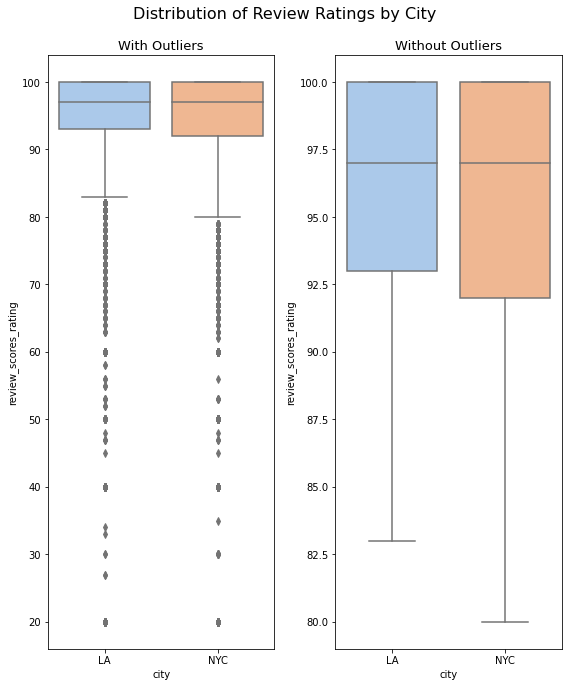

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,10))
sns.boxplot(x='city',y='review_scores_rating',data=listings_df,palette="pastel", ax=ax[0])
sns.boxplot(x='city',y='review_scores_rating',data=listings_df,palette="pastel", showfliers=False,ax=ax[1])
fig.suptitle('Distribution of Review Ratings by City',fontsize=16)
ax[0].set_title('With Outliers', fontsize=13)
ax[1].set_title('Without Outliers', fontsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

##### *'Poorly' Rated Airbnbs*

Since we adjusted our previous analysis of ratings because outliers skewed the picture, let's take a look and see what we can glean from them instead. Since the vast majority of ratings fall at 80% and above, we'll identify these "poorly"-rated Airbnbs as any Airbnb with a rating below 80%.

In [ ]:
# Sorted in order to standardize 'hue' assignment in graph
poor_ratings=listings_df[listings_df['review_scores_rating'] < 80].sort_values('city')
poor_reviews=poor_ratings[poor_ratings['number_of_reviews'] <= 25].sort_values('city')

Ratings are directly correlated to the number of reviews given. All the graphs display the relationship between the number of reviews an Airbnb receives and the corresponding rating. However, each graph is filtered as follows:

1.   Left-hand side: Includes all Airbnbs.
2.   Middle: Includes only Airbnbs with ratings less than 80%.
3.   Right-hand side: Includes only Airbnbs with ratings less than 80% and have 25 or fewer reviews.

Each graph progressively zooms in on more specific details.

As we can see, it's apparent that the vast majority of Airbnbs with "poor" ratings have just a handful of reviews, which would heavily impact the rating.

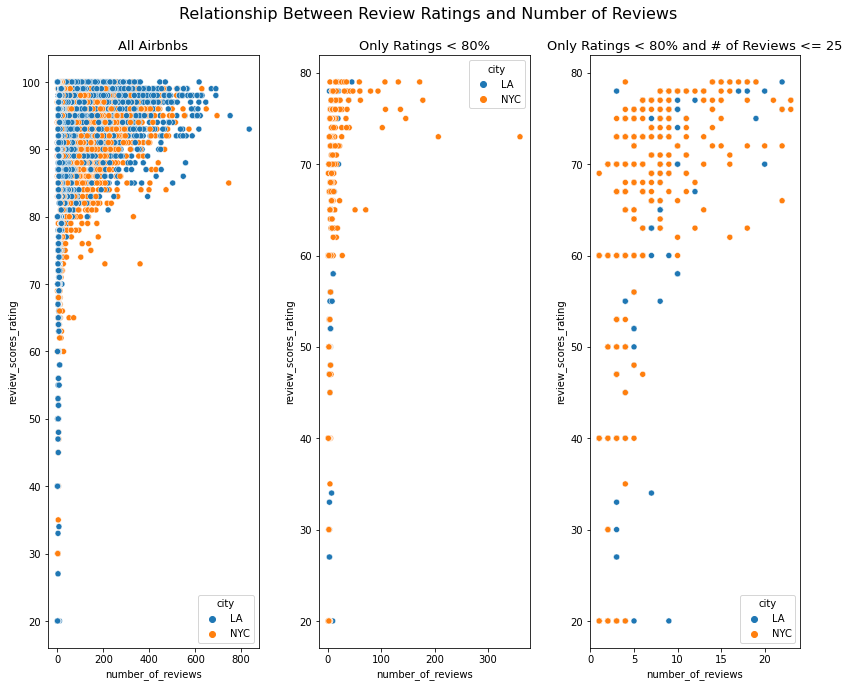

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,10))
sns.scatterplot(data=listings_df, x='number_of_reviews',y='review_scores_rating',hue='city',ax=ax[0])
sns.scatterplot(data=poor_ratings, x='number_of_reviews',y='review_scores_rating',hue='city',ax=ax[1])
sns.scatterplot(data=poor_reviews, x='number_of_reviews',y='review_scores_rating',hue='city',ax=ax[2])
fig.suptitle('Relationship Between Review Ratings and Number of Reviews',fontsize=16)
ax[0].set_title('All Airbnbs', fontsize=13)
ax[1].set_title('Only Ratings < 80%', fontsize=13)
ax[2].set_title('Only Ratings < 80% and # of Reviews <= 25', fontsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

##### *Superhosts*

Airbnb defines superhosts as "experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests" and they are identified with a badge on their profile.

Since this attribute is basically a direct measure of how great an Airbnb is, can this explain why LA Airbnbs seem to be outperforming NYC Airbnbs?

The answer is yes, this is entirely possible! Superhosts in LA make up about 32% of all hosts, whereas in NYC, they make up only about 18%.

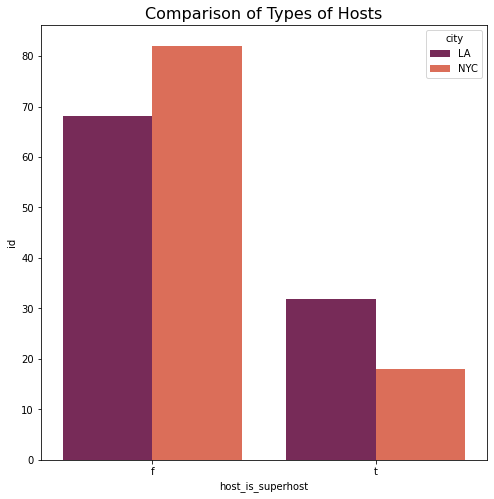

In [ ]:
# First, we standardize.
superhosts=listings_df.groupby(['city','host_is_superhost']).agg({'id': 'count'})
superhosts=superhosts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
superhosts.reset_index(inplace=True)

fig, ax1 = plt.subplots(figsize=(8,8))
sns.barplot(x='host_is_superhost', y='id', hue='city', data=superhosts, palette='rocket')
plt.title('Comparison of Types of Hosts',fontsize=16)
plt.show()

##### *Host Listing Count*

Generally speaking, the more practice people have, the better they are at their job. Does this rule apply to AirBnB host? In our data, this question translates to are hosts managing more properties better at their jobs and consequently receive better ratings? Or they become more distracted and are perceived to be worse hosts?

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


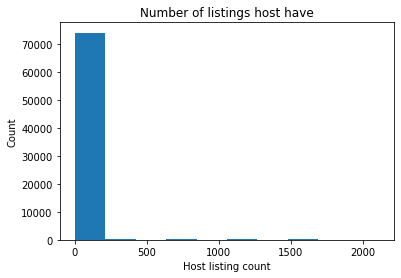

In [ ]:
# Histogram of host listing count
plt.hist(listings_df['host_listings_count'])
plt.xlabel('Host listing count')
plt.ylabel('Count')
plt.title('Number of listings host have')
plt.show()

Well, it looks like some of our hosts may either be trillionaire or property managers. And it seems that almost 90% of the hosts have equal or fewer than 10 listings. And looking at this subset of hosts, it seems that as the number of listings increases, the median review scores decreases. But the change is quite small and the variances are too large enough to arrive at an definite conclusion.

In [ ]:
listing_count = listings_df['host_listings_count']
print((listing_count <= 10).mean())

0.8893602308541337


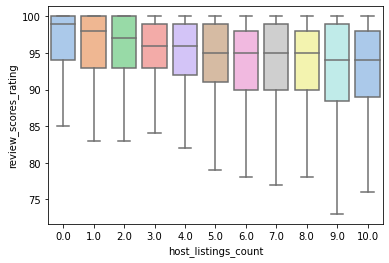

In [ ]:
sns.boxplot(x='host_listings_count',y='review_scores_rating',data=listings_df[listings_df.host_listings_count<=10],palette="pastel", showfliers=False)

<a name="final-cleaning"></a>
### Final Cleaning and Formatting of Listings Data

Now that we have thoroughly explored the data, it's time to prepare it for our analyses.

#### Drop Null Host Names
From our initial analysis in *Null Host Names?*, we determined that we could drop these 27 null host names without impacting our analysis.

In [ ]:
listings_df.dropna(axis=0,subset={'host_name'},inplace=True)

#### Drop Irrelevant Columns

We have pinpointed the columns that are relevant for our purposes, so we can drop everything else.

In [ ]:
cols = pd.Series(listings_df.columns)

main_cols_drop = ['listing_url','scrape_id','last_scraped','picture_url','host_url','host_thumbnail_url',\
                  'host_picture_url','host_total_listings_count','host_verifications','neighbourhood','bathrooms',\
                  'calendar_updated', 'license','calendar_last_scraped','host_neighbourhood','year']

# Drop all columns about minimum night except for 'minimum_nights'
night_cols_drop = list(cols[cols.apply(lambda x: '_nights' in x)])[1:]

# Drop irrelevant availability columns
avail_cols_drop = list(cols[cols.apply(lambda x: 'availability' in x)])

# Drop all reviews count columns except for 'number_of_reviews'
review_cols_drop = list(cols[cols.apply(lambda x: 'number_of_reviews_' in x)])

# Drop host listing count by room type
listcount_cols_drop = list(cols[cols.apply(lambda x: 'calculated_host_listings_count' in x)])

# Other features to drop
other_cols_drop = ['property_type', 'bathrooms_text', 'last_review', 'instant_bookable', 'reviews_per_month', 'host_id']

drop_cols = main_cols_drop + night_cols_drop + avail_cols_drop + review_cols_drop + listcount_cols_drop + other_cols_drop

listings_df.drop(columns=drop_cols, inplace=True)

#### Booleans
For our model, we want Boolean features, but they need to be numeric. Let's cast them to zeroes and ones.

In [ ]:
listings_df['host_is_superhost']=listings_df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
listings_df['host_has_profile_pic']=listings_df['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
listings_df['host_identity_verified']=listings_df['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)

#### Text Cleaning

Since our analysis also depends on qualitative features, we need to make sure that they are generally clean. In this section, we'll remove obviously bad patterns, such as HTML tags and escape characters from our descriptive features.

In [ ]:
# Function to remove bad patterns
def remove_bad_patterns(text):
    h = re.compile("(<.*?>)")
    n = re.compile("\n")
    r = re.compile("\r")
    t = re.compile("\t")
    l = re.compile("\$")
    
    text = h.sub("",text)
    text = n.sub(" ",text)
    text = r.sub(" ",text)
    text = t.sub(" ",text)
    text = l.sub(" ",text)

    return text

In [ ]:
listings_df['description'] = listings_df['description'].apply(lambda x: remove_bad_patterns(str(x)))
listings_df['host_about'] = listings_df['host_about'].apply(lambda x: remove_bad_patterns(str(x)))
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].apply(lambda x: remove_bad_patterns(str(x)))

In [ ]:
# Remove unclosed breaks at end of descriptions
listings_df['description'] = listings_df['description'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))
listings_df['host_about'] = listings_df['host_about'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))

In [ ]:
listings_df['description']=listings_df['description'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)
listings_df['host_about']=listings_df['host_about'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)
listings_df['neighborhood_overview']=listings_df['neighborhood_overview'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)

#### Final Listings Data

Our listings data is now ready to be used in our analysis and in conjunction with the other sources.

In [ ]:
listings_df.head(5)

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city
0,109,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi Paolo, MIT MBA (P...",None,NaN,0.00,0,1.0,1,1,Culver City,Other Cities,33.98209,-118.38494,Entire home/apt,6,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",115.0,30,2,2011-08-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,LA
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,0.70,0.25,0,6.0,1,1,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,2,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC
2,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,Chas.,2008-09-16,"Los Angeles, California, United States",Writer. Literary Manager. Photographer. Pro...,within a few hours,1.00,1.00,1,2.0,1,1,Hollywood,City of Los Angeles,34.09768,-118.34602,Private room,1,1.0,1.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",75.0,30,27,2014-06-09,97.0,10.0,10.0,10.0,10.0,10.0,10.0,LA
3,2732,Zen Life at the Beach,An oasis of tranquility awaits you.The spaceTh...,"This is the best part of Santa Monica. Quiet, ...",Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within an hour,0.92,0.50,0,2.0,1,1,Santa Monica,Other Cities,34.00475,-118.48127,Private room,1,1.0,1.0,"[""Hangers"", ""Refrigerator"", ""Dishes and silver...",155.0,1,21,2011-06-06,94.0,9.0,9.0,9.0,9.0,10.0,9.0,LA
4,2864,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,Bernadine,2008-09-25,"Bellflower, California, United States","Fair, open, honest and very informative for ne...",None,NaN,NaN,0,1.0,1,1,Bellflower,Other Cities,33.87619,-118.11397,Entire home/apt,2,1.0,1.0,"[""Bed linens"", ""Essentials"", ""TV"", ""Free stree...",50.0,30,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA


## NYC and LA Crime Data

The goal of collecting and integrating NYC and LA crime data with the Airbnb listings data is to create a proxy for neighborhood safety. Crime level is a factor that hosts cannot control, but will impact their Airbnb nonetheless.

*Caveat*: The NYPD crime report data only provides borough/precinct-level identifier in each crime report. Given that there are 5 boroughs in total in NYC, we acknowledge neighborhoood characteristics could vary within a borough. However, this is the best information we could find so far that best represents safety in each region.  

### NYC Crime Data

In [ ]:
!unzip '/content/drive/Shareddrives/CIS545: AirBnB/NYPD_Complaint_Data_Historic.csv.zip'
crime_df_org = pd.read_csv('/content/NYPD_Complaint_Data_Historic.csv')

Archive:  /content/drive/Shareddrives/CIS545: AirBnB/NYPD_Complaint_Data_Historic.csv.zip
  inflating: NYPD_Complaint_Data_Historic.csv  
  inflating: __MACOSX/._NYPD_Complaint_Data_Historic.csv  


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### First Glance

Let's look at how the NYC crime data is broken down and see what might be relevant for our analysis.

The report is quite detailed, but we don't need such granular information. However, we can see that it does provide telling information such as when the report was filed, what kind and level of crime was committed and within which borough.

In [ ]:
crime_df_org.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,724718389,09/04/2014,17:25:00,09/04/2014,17:35:00,81.0,09/04/2014,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,BROOKLYN,OPPOSITE OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1005945.0,188862.0,NaN,NaN,NaN,NaN,40.685041,-73.921777,"(40.685040958, -73.921776995)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F
1,191133903,10/12/2016,07:40:00,10/12/2016,07:45:00,121.0,10/12/2016,109,GRAND LARCENY,417.0,"LARCENY,GRAND FROM PERSON,PURS",COMPLETED,FELONY,STATEN ISLAND,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,947034.0,171375.0,UNKNOWN,BLACK,U,NaN,40.636991,-74.134093,"(40.63699139, -74.134092508)",PATROL BORO STATEN ISLAND,NaN,45-64,WHITE HISPANIC,F
2,720151206,09/28/2012,13:30:00,09/28/2012,14:00:00,41.0,10/19/2012,109,GRAND LARCENY,413.0,"LARCENY,GRAND BY FALSE PROMISE",COMPLETED,FELONY,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1014179.0,239453.0,NaN,WHITE HISPANIC,M,NaN,40.823876,-73.891863,"(40.823876276, -73.891862968)",PATROL BORO BRONX,NaN,45-64,WHITE HISPANIC,F
3,232242098,03/24/2015,15:45:00,NaN,NaN,46.0,03/24/2015,341,PETIT LARCENY,339.0,"LARCENY,PETIT FROM OPEN AREAS,",COMPLETED,MISDEMEANOR,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1009041.0,247401.0,NaN,BLACK,M,NaN,40.845707,-73.910398,"(40.845707148, -73.910398033)",PATROL BORO BRONX,NaN,<18,WHITE HISPANIC,F
4,708078702,05/20/2017,04:02:00,05/20/2017,04:09:00,109.0,05/20/2017,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,QUEENS,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1031779.0,217663.0,25-44,WHITE HISPANIC,M,NaN,40.763992,-73.828426,"(40.763991557, -73.828425559)",PATROL BORO QUEENS NORTH,NaN,25-44,BLACK,M


Let's see what the breakdown is. As usual, there will be some clean-up that needs to be done.

In [ ]:
crime_df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983207 entries, 0 to 6983206
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         int64  
 1   CMPLNT_FR_DT       object 
 2   CMPLNT_FR_TM       object 
 3   CMPLNT_TO_DT       object 
 4   CMPLNT_TO_TM       object 
 5   ADDR_PCT_CD        float64
 6   RPT_DT             object 
 7   KY_CD              int64  
 8   OFNS_DESC          object 
 9   PD_CD              float64
 10  PD_DESC            object 
 11  CRM_ATPT_CPTD_CD   object 
 12  LAW_CAT_CD         object 
 13  BORO_NM            object 
 14  LOC_OF_OCCUR_DESC  object 
 15  PREM_TYP_DESC      object 
 16  JURIS_DESC         object 
 17  JURISDICTION_CODE  float64
 18  PARKS_NM           object 
 19  HADEVELOPT         object 
 20  HOUSING_PSA        object 
 21  X_COORD_CD         float64
 22  Y_COORD_CD         float64
 23  SUSP_AGE_GROUP     object 
 24  SUSP_RACE          object 
 25  SUSP_SEX          

#### Basic Formatting

Again, we need to preprocess the most important parts of our data to reflect the correct datatypes so that our exploration is meaningful.

First, we'll rename the columns to make them more descriptive and we'll only keep the columns of interest.

In [ ]:
crime_df = crime_df_org.rename(columns={'LAW_CAT_CD': 'offense_level', 'CRM_ATPT_CPTD_CD':'crime_completion', 'CMPLNT_FR_DT':'date', 'OFNS_DESC':'offense_desc', 'BORO_NM':'borough_name'})

In [ ]:
crime_df = crime_df[['date', 'borough_name', 'offense_level', 'offense_desc', 'crime_completion']]

Next, we'll update the 'date' column to actually be a date type.

In [ ]:
def clean_date(date):
  if re.findall('(/10)[0-9]{2}$', date):
    y = re.findall('/10([0-9]{2})$', date)[0]
    return re.sub('/10[0-9]{2}', '/20'+y, date)
  return date
  
crime_df['date'] = crime_df['date'].apply(lambda x: clean_date(str(x)))
crime_df['date'] = pd.to_datetime(crime_df['date'], format='%m/%d/%Y')
crime_df['year'] = crime_df['date'].apply(lambda x: x.year)

Since the report holds data from as far back as 1900, we need to filter the data for incidents more related to our timeframe, otherwise our analysis will be skewed based on a century's worth of data.

From our previous analysis of the listings data, we determined that the number of hosts that joined Airbnb significantly increased in 2010, which means that the number of Airbnbs that guests can choose from also dramatically increased around that time. As a result, we'll filter our data to only include incidents from 2010 to 2019 (pre-pandemic).

In [ ]:
crime_df_2010 = crime_df[(crime_df['year']>=2010) & (crime_df['year']<=2019)]

#### Let's Explore!

Let's get a sense of how crime is broken down in NYC.

In [ ]:
crime_borough = crime_df_2010.groupby(['year','borough_name','offense_level']).count()
crime_borough.reset_index(inplace=True)

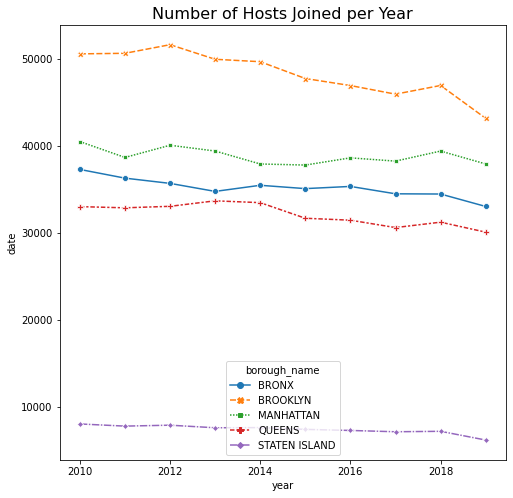

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(data=crime_borough, x='year', y='date', hue='borough_name', markers=True, style='borough_name',ci=None)
plt.title('Number of Hosts Joined per Year', fontsize=16)
plt.show()

In [ ]:
crime_df['offense_level'].value_counts()

MISDEMEANOR    3938246
FELONY         2150008
VIOLATION       894953
Name: offense_level, dtype: int64

In [ ]:
crime_df['crime_completion'].value_counts()

COMPLETED    6863758
ATTEMPTED     119442
Name: crime_completion, dtype: int64

In [ ]:
crime_df['offense_desc'].value_counts()

PETIT LARCENY                      1165360
HARRASSMENT 2                       880644
ASSAULT 3 & RELATED OFFENSES        731300
CRIMINAL MISCHIEF & RELATED OF      699377
GRAND LARCENY                       607704
                                    ...   
FELONY SEX CRIMES                       10
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           4
KIDNAPPING AND RELATED OFFENSES          3
UNDER THE INFLUENCE OF DRUGS             3
Name: offense_desc, Length: 71, dtype: int64

#### Final Cleaning and Formatting of NYC Crime Data

The most important data from this dataset as it relates to our Airbnb listings data is the number of crimes by borough. Therefore, we will pull a summary by year and borough to merge to our listings data.

In [ ]:
crime_df_summary = crime_df_2010.drop(columns=['date', 'offense_desc', 'offense_level']).groupby(['year', 'borough_name']).count()
crime_df_summary.reset_index(inplace=True)
crime_df_summary = crime_df_summary.rename(columns={'crime_completion': 'crime_count'})

Because the crime data is heavily skewed based on the population of a borough, we will normalize and calculate crime on a per capita basis instead.

We pulled the census population estimate by borough in 2019 from the [official Census website](https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219) and capture them here.


In [ ]:
nyc_pop_dict = {'borough':['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'], 'Population': [1418207, 2559903, 1628706, 2253858, 476143]}
nyc_pop = pd.DataFrame(nyc_pop_dict)

After normalizing the crime summary, our NYC crime data is now ready to be integrated with our listings data.

In [ ]:
crime_df_summary = crime_df_summary.merge(nyc_pop, left_on='borough_name', right_on='borough').drop(columns = 'borough')
crime_df_summary['crime_per_capita'] = crime_df_summary.crime_count/crime_df_summary.Population
crime_df_summary.drop(columns=['crime_count', 'Population'], inplace=True)

In [ ]:
crime_df_summary.head(5)

,year,borough_name,crime_per_capita
0,2010.0,BRONX,0.078807
1,2011.0,BRONX,0.076695
2,2012.0,BRONX,0.075423
3,2013.0,BRONX,0.073473
4,2014.0,BRONX,0.074958


### LA Crime Data

In [ ]:
la_crime = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Data/la crime.csv')

#### First Glance and Formatting

The LA crime data we collected was already cleaned and processed. It contains data on crime per capita in each neighborhood, which cleanly maps to the LA neighborhoods in our listings data. Here, we'll just read it in and keep the relevant columns.

In [ ]:
la_crime.head(5)

,RANK,NEIGHBORHOOD,PER CAPITA,TOTAL
0,1,Chesterfield Square,126.9,81
1,2,Vermont Vista,122.9,306
2,3,Vermont Knolls,110.4,238
3,4,Harvard Park,109.3,119
4,5,Broadway-Manchester,105.4,272


In [ ]:
la_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RANK          209 non-null    int64  
 1   NEIGHBORHOOD  209 non-null    object 
 2   PER CAPITA    209 non-null    float64
 3   TOTAL         209 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.7+ KB


In [ ]:
la_crime = la_crime[['NEIGHBORHOOD', 'PER CAPITA']]
la_crime.columns = ['neighborhood', 'crime_per_capita']

In [ ]:
la_crime.head(5)

,neighborhood,crime_per_capita
0,Chesterfield Square,126.9
1,Vermont Vista,122.9
2,Vermont Knolls,110.4
3,Harvard Park,109.3
4,Broadway-Manchester,105.4


## NYC and LA Income Data

Similar to why we will use crime data in our analysis, we will also use NYC and LA income data to create a proxy for neighborhood affluence. This is also an external factor that hosts cannot control, but one that can affect visitors' perceptions and decisions. It may also enable the host to increase their price as the neighborhood affluence increases or force the host to decrease their price if it decreases.

We pull median income data instead of average because we want to eliminate biases in the figures. Especially in cities like NYC and LA, there could be a handful of extremely wealthy people in a given neighborhood that could inflate the average income and therefore be very misleading when used as a proxy for neighborhood affluence.

### NYC Income Data

In [ ]:
income_df_orig = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Median Incomes.csv', skiprows=5)

#### First Glance

The data generally looks good already, but there's some preprocessing that still needs to be done.

In [ ]:
income_df_orig.head(5)

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
0,Riverdale,All Households,2005,Dollars,63435.46009,208
1,Williamsbridge,All Households,2005,Dollars,52141.77239,212
2,Throgs Neck,All Households,2005,Dollars,57712.50261,210
3,Pelham Parkway,All Households,2005,Dollars,52782.17672,211
4,Morrisania,All Households,2005,Dollars,24589.9512,203


At the very least, the 'Data' column should be numeric so let's change that first before we explore...

In [ ]:
income_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Location        3900 non-null   object
 1   Household Type  3900 non-null   object
 2   TimeFrame       3900 non-null   int64 
 3   DataFormat      3900 non-null   object
 4   Data            3900 non-null   object
 5   Fips            3900 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 182.9+ KB


... Whoops! We can't immediately change this to be numeric -- it looks like there's some invalid data. We'll poke through the other columns first to determine what needs to be kept or dropped before we handle these.

In [ ]:
income_df_orig[income_df_orig['Data'] == '#VALUE!']

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
1706,Upper East Side,Families with Children,2011,Dollars,#VALUE!,108
2750,Murray Hill/Stuyvesant,Families with Children,2015,Dollars,#VALUE!,106
2752,Battery Park/Tribeca,Families with Children,2015,Dollars,#VALUE!,101
2753,Greenwich Village,Families with Children,2015,Dollars,#VALUE!,102


#### Let's Explore!

##### *Household Type*
What does "household type" constitute? From looking at the values, it looks like the dataset provides the median income of households of various types for a given neighborhood.

In [ ]:
income_df_orig['Household Type'].unique()

array(['All Households', 'Families', 'Families with Children',
       'Families without Children'], dtype=object)

In [ ]:
income_df_orig[(income_df_orig['Location'] == 'Upper East Side') & (income_df_orig['TimeFrame'] == 2015)]

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
2616,Upper East Side,All Households,2015,Dollars,110557.62253,108
2681,Upper East Side,Families,2015,Dollars,217538.00946,108
2746,Upper East Side,Families with Children,2015,Dollars,248791.07051,108
2811,Upper East Side,Families without Children,2015,Dollars,207441.89596,108


Since we want to consider all households in a given neighborhood regardless of whether they are a family or not, we will filter our dataset for only 'All Households'.

##### *Other Attributes*

Let's glance at the other columns to see if they're anything particularly useful.

FIPS codes uniquely define a geographic area, but since we have neighborhood location, we won't need this information.

In [ ]:
income_df_orig['Fips'].unique()

array([    208,     212,     210,     211,     203,     206,     207,
           205,     204,     209,     201,     202,     112,     109,
           110,     111,     108,     107,     104,     105,     106,
           103,     101,     102,     503,     502,     501,     301,
           304,     303,     302,     306,     308,     316,     305,
           318,     317,     309,     307,     310,     312,     314,
           315,     311,     313,     401,     403,     407,     411,
           413,     408,     404,     406,     402,     405,     409,
           412,     410,     414,   36005,   36047,   36061,   36081,
         36085, 3651000])

All amounts are also in US Dollars, so we won't need the "DataFormat" column as well.

In [ ]:
income_df_orig['DataFormat'].unique()

array(['Dollars'], dtype=object)

Finally, looking at the years, we can see that this dataset does hold information relevant to our time period. To match this with our crime dataset, we will also filter this to retain data from 2010 and later.

In [ ]:
income_df_orig['TimeFrame'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

#### Final Cleaning and Formatting of NYC Income Data

After the above analysis, we now know what we can safely drop and reformat.

First, we'll filter our dataset to keep only the median incomes of all households and only those from 2010 and later.

In [ ]:
income_df = income_df_orig[income_df_orig['Household Type']=='All Households']
income_df = income_df[income_df['TimeFrame']>=2010]

We also determined that the only columns of interest to us were location, year and income. Let's drop all the other columns.

In [ ]:
income_df = income_df.drop(columns=['Household Type', 'DataFormat', 'Fips'])

Finally, we'll rename the columns to be more descriptive and also change the datatype of income to be numeric.

In [ ]:
income_df.columns = ['neighborhood', 'year', 'income']
income_df.reset_index(drop=True, inplace=True)

income_df['income'] = income_df['income'].apply(lambda x: round(float(x)))

In [ ]:
income_df.head(5)

,neighborhood,year,income
0,Riverdale,2010,58804
1,Williamsbridge,2010,51674
2,Throgs Neck,2010,55497
3,Pelham Parkway,2010,51251
4,Morrisania,2010,24179


##### *Additional Exploration*

Now that our data is filtered and cleaned, we want to get a better understanding of what neighborhood dynamics are like between the 65 neighborhoods.

In [ ]:
income_df.neighborhood.unique()

array(['Riverdale', 'Williamsbridge', 'Throgs Neck', 'Pelham Parkway',
       'Morrisania', 'East Tremont', 'Bedford Park', 'University Heights',
       'Concourse/Highbridge', 'Unionport/Soundview', 'Mott Haven',
       'Hunts Point', 'Washington Heights', 'Manhattanville',
       'Central Harlem', 'East Harlem', 'Upper East Side',
       'Upper West Side', 'Chelsea/Clinton', 'Midtown Business District',
       'Murray Hill/Stuyvesant', 'Lower East Side',
       'Battery Park/Tribeca', 'Greenwich Village', 'Tottenville',
       'South Beach', 'St. George', 'Williamsburg/Greenpoint', 'Bushwick',
       'Bedford Stuyvesant', 'Fort Greene/Brooklyn Hts', 'Park Slope',
       'Crown Heights North', 'Brownsville', 'East New York', 'Canarsie',
       'East Flatbush', 'Crown Heights South', 'Sunset Park', 'Bay Ridge',
       'Borough Park', 'Flatbush/Midwood', 'Sheepshead Bay',
       'Bensonhurst', 'Coney Island', 'Astoria', 'Jackson Heights',
       'Flushing', 'Bayside', 'Queens Village', 

**Top 10 Neighborhoods**

Below are the top 10 neighborhoods with the highest median income as of 2019. 

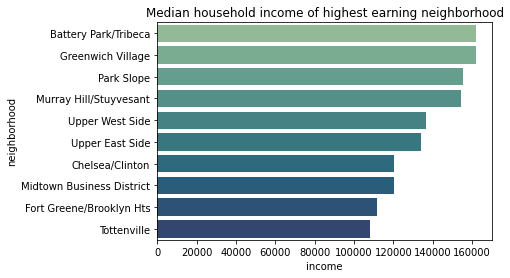

In [ ]:
top10neighborhood = income_df[income_df['year']==2019].sort_values(by='income', ascending=False, ignore_index=True).head(10)
sns.barplot(data=top10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of highest earning neighborhood')
plt.show()

How has the median income changed over the past ten years for the top 10 neighborhoods? It seems like they have only gotten increasingly wealthier over time.

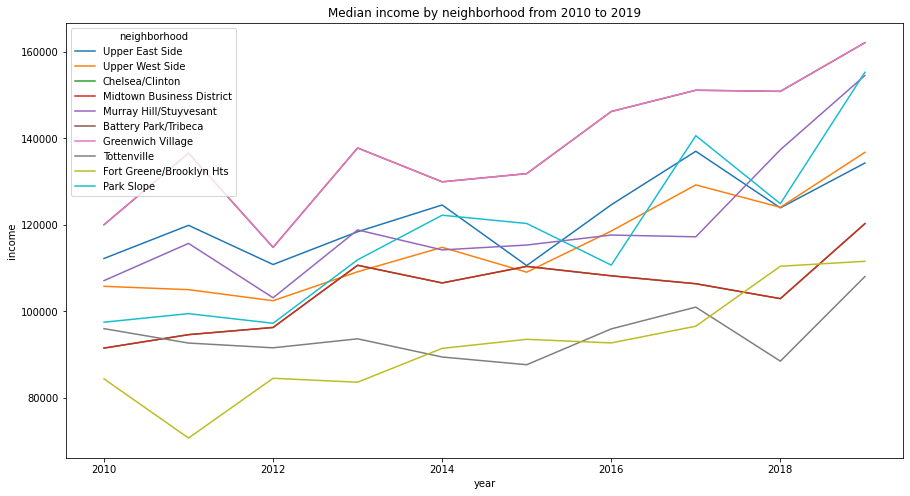

In [ ]:
neighborhood_change = income_df[income_df['neighborhood'].isin(top10neighborhood['neighborhood'])]
plt.figure(figsize=(15,8))
plt.title('Median income by neighborhood from 2010 to 2019')
sns.lineplot(data=neighborhood_change, x='year', y='income', hue='neighborhood')
plt.show()

**Bottom 10 Neighborhoods**

Below are the bottom 10 neighborhoods with the lowest median income as of 2019. 

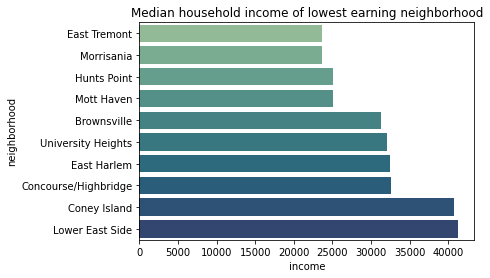

In [ ]:
bot10neighborhood = income_df[income_df['year']==2019].sort_values(by='income', ascending=True, ignore_index=True).head(10)
sns.barplot(data=bot10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of lowest earning neighborhood')
plt.show()

The disparity between the top 10 and bottom 10 neighborhoods is immense. How has the median income changed over the past ten years for the bottom 10 neighborhoods?

Although some neighborhoods have fared marginally better from 2010 to 2019, the trends are much flatter, and even negative in some cases, compared to that of the top 10 neighborhoods.

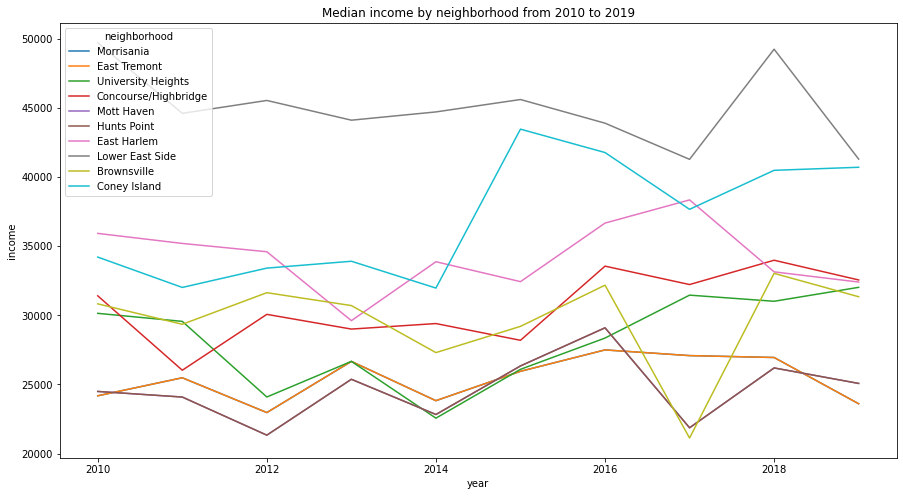

In [ ]:
neighborhood_change = income_df[income_df['neighborhood'].isin(bot10neighborhood['neighborhood'])]
plt.figure(figsize=(15,8))
plt.title('Median income by neighborhood from 2010 to 2019')
sns.lineplot(data=neighborhood_change, x='year', y='income', hue='neighborhood')
plt.show()

It will be interesting to see how this income disparity factors into our Airbnb analysis.

### LA Income Data

In [ ]:
la_income = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Data/Median_Household_Income_by_Census_Tract.csv')
census_map = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Data/Census_Tract_Locations__LA_.csv')

#### First Glance and Cleaning

Unlike the NYC income data, we needed to preprocess our LA income data a bit. Although we also collected median incomes, we couldn't obtain it by neighborhood; instead, we have median incomes by tracts. Consequently, we also obtained a mapping between tract locations and neighborhoods to better integrate the incomes for our purposes.

In [ ]:
la_income.head(5)

,OBJECTID,CT10,OID,tract,B19013e1,B19013Ae1,B19013Be1,B19013Ce1,B19013De1,B19013Ee1,B19013Fe1,B19013Ge1,B19013He1,B19013Ie1,ShapeSTArea,ShapeSTLength
0,1,911001,2254,911001,50732,50640,0,0,0,0,47750,0,50518,49107,4.025736e+09,353933.808192
1,2,980003,2319,980003,0,0,0,0,0,0,0,0,0,0,2.078690e+09,273188.863210
2,3,930301,2316,930301,75313,83000,0,0,0,0,0,0,83833,0,1.111802e+10,628603.531323
3,4,573003,1869,573003,63182,75516,0,0,50750,0,62857,125938,75938,62857,4.824002e+06,9050.008458
4,5,297602,986,297602,65729,65208,0,0,112763,0,50313,0,68068,51196,6.697031e+06,12308.315385


In [ ]:
census_map.head(5)

,GEOID,Tract,Tract Number,Neighborhood,Location,Latitude,Longitude
0,1400000US06037101110,"Census Tract 1011.10, Los Angeles County, Cali...",101110,Tujunga,"(34.2595555, -118.293602)",34.259555,-118.293602
1,1400000US06037101122,"Census Tract 1011.22, Los Angeles County, Cali...",101122,Tujunga,"(34.267357, -118.29024)",34.267357,-118.290240
2,1400000US06037101210,"Census Tract 1012.10, Los Angeles County, Cali...",101210,Tujunga,"(34.251998, -118.2926875)",34.251998,-118.292687
3,1400000US06037101220,"Census Tract 1012.20, Los Angeles County, Cali...",101220,Tujunga,"(34.2511895, -118.281014)",34.251190,-118.281014
4,1400000US06037101300,"Census Tract 1013, Los Angeles County, California",101300,Tujunga,"(34.2455945, -118.271731)",34.245595,-118.271731


Using information from the data source, we know what the relevant columns are in our main income. Let's limit the data to just these first.

In [ ]:
la_income = la_income[['tract', 'B19013e1']]
la_income.columns = ['tract', 'income']

census_map = census_map[['Tract Number', 'Neighborhood']]
census_map.columns = ['tract', 'neighborhood'] 

Looking at the datatypes, we can see that everything looks good! No casting or formatting is necessary in this regard.

In [ ]:
la_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tract   2344 non-null   int64
 1   income  2344 non-null   int64
dtypes: int64(2)
memory usage: 36.8 KB


In [ ]:
census_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tract         2344 non-null   int64 
 1   neighborhood  2344 non-null   object
dtypes: int64(1), object(1)
memory usage: 36.8+ KB


Now we'll map each tract to the corresponding neighborhood to obtain a dataset consistent with the rest of our datasets.

In [ ]:
la_income_neighborhood = la_income.merge(census_map,left_on='tract', right_on='tract').drop(columns='tract')

Let's look at what we have.

In [ ]:
la_income_neighborhood.head(5)

,income,neighborhood
0,50732,Southeast Antelope Valley
1,0,Northeast Antelope Valley
2,75313,Angeles Crest
3,63182,Long Beach
4,65729,San Pedro


Hmmm, from the get-go we can see that we could be missing data. Leaving these as zero could significantly impact our analysis so we'll take a look at 'Northeast Antelope Valley' and see what we can do with it.

In [ ]:
la_income_neighborhood[la_income_neighborhood['neighborhood'] == 'Northeast Antelope Valley']

,income,neighborhood
1,0,Northeast Antelope Valley
171,44643,Northeast Antelope Valley
190,54012,Northeast Antelope Valley
2187,45897,Northeast Antelope Valley
2198,47078,Northeast Antelope Valley
2247,25938,Northeast Antelope Valley


Because each neighborhood maps to multiple tracts, we should be fine to drop zeroes since we need to average the incomes of each tract to obtain a general approximation of income per neighborhood. 

In [ ]:
# Drop all tract regions with 0 income
la_income_neighborhood = la_income_neighborhood[la_income_neighborhood.income!=0]

# Aggregate income on neighborhood level
la_income_neighborhood = la_income_neighborhood.groupby('neighborhood').mean().reset_index()

In [ ]:
la_income_neighborhood.head(5)

,neighborhood,income
0,Acton,102877.500000
1,Adams-Normandie,34859.600000
2,Agoura Hills,130459.666667
3,Agua Dulce,84048.000000
4,Alhambra,59975.250000


#### Let's Explore!

Now that our data is filtered and cleaned, we want to get a better understanding of what neighborhood dynamics are like between the 250+ neighborhoods.

Our exploration is more limited because we don't have year-over-year data. The only data we have is from 2018.

**Top 10 Neighborhoods**

Below are the top 10 neighborhoods with the highest median income as of 2018. 

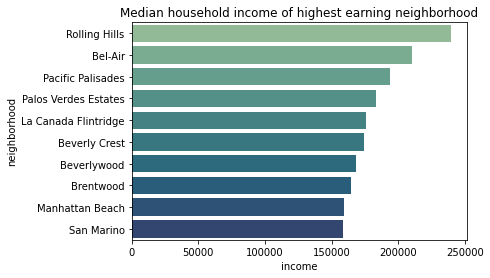

In [ ]:
top10neighborhood = la_income_neighborhood.sort_values(by='income', ascending=False, ignore_index=True).head(10)
sns.barplot(data=top10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of highest earning neighborhood')
plt.show()

**Bottom 10 Neighborhoods**

Below are the bottom 10 neighborhoods with the lowest median income as of 2018. 

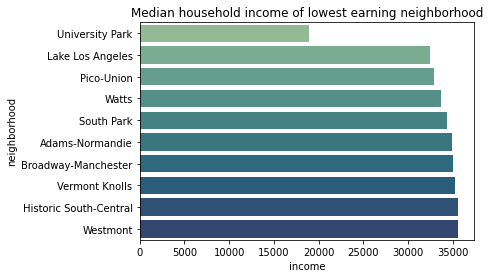

In [ ]:
bot10neighborhood = la_income_neighborhood.sort_values(by='income', ascending=True, ignore_index=True).head(10)
sns.barplot(data=bot10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of lowest earning neighborhood')
plt.show()

Just at a glance, we can see the disparities in income are even more immense than those of top 10 and bottom 10 neighborhoods in NYC.

# Data Integration

Now we are finally ready to integrate all of our datasets. The listings data, containing data for both NYC and LA, is our main dataset, so we'll need to merge the NYC and LA crime and income datasets into it.

We'll do this in parts since the crime and income datasets are a bit different between the cities. We'll first break up the listings dataset by city and then integrate separately.

Before we do that, we display the counts of tuples for each city within our main dataset. As we integrate, we need to ensure that we do not gain or lose records without valid reason.

In [ ]:
listings_df.groupby('city')['id'].nunique()

city
LA     30523
NYC    44649
Name: id, dtype: int64

In [ ]:
listings_nyc = listings_df[listings_df.city == "NYC"]
listings_la = listings_df[listings_df.city == "LA"]

## Merge the NYC Datasets

To better streamline the integration, we decided to keep all necessary steps in one function. The function is thoroughly commented below, but a general synopsis of the procedures are as follows:
1.   Merge the listings data with the crime data.
  * After inspection, we found that the *neighbourhood_group_cleansed* variable in the Airbnb listing data corresponds to different boroughs. Therefore, we used this as a key in joining the listing and crime dataset.
2.   Merge the listings/crime data with the income data.
  * Identical neighborhoods were named slightly different in each dataset. We performed a Cartesian product of all neighborhoods between the two datasets and ran a check to find matching neighborhoods (either the names were equal or one was a substring of the other). Only these matches were kept.
    > We created a function *check()* specifically to match neighborhoods. Two manual checks were built in because the names of the neighborhoods were too similar, but they were indeed separate, distinct neighborhoods.
  * The mapping that resulted enabled us to link the listings and income.
3.   Format the final dataset.
  * We filled missing income data with the median income. We avoided using average because outliers heavily influence it. Especially in NYC where wealth disparities are enormous, we used median to curtail this impact.
  * Finally, we dropped some redundant columns.


**Note**: 
1.   Since the listing data was last updated in 2020, we believe more recent crime data would better reflect the crime map in corresponding boroughs; however, since that data is unavailable, we will use 2019's crime counts as a proxy for the safety of the listing location.
2.   The crime data includes complaints of different types: Misdemeanors, felonies and violations. To gauge the potential safety level in certain neighborhoods, we count only the violations and felonies. 
3.   Given more time, an idea we considered was using a weighted crime count/income level given the number of reviews in each year. 

In [ ]:
def check(x, y):
  '''
  Check if two neighborhoods are identical, or a substring of each other
  *** Includes manual checks for similar neighborhood names

  returns: boolean, True if substring or equal
  '''
  # Manual checks
  if (x=='East Flatbush') & (y=='Flatbush'):
    return False
  if (x=='Queens') & (y=='Queens Village'):
    return False

  if x==y:
    return True
  if x in y:
    return True
  if y in x:
    return True
  return False


def merge_nyc_crime_income(crime_data, income_data, listing_df):
  '''
  Take in crime and income dataset, join with Airbnb listing data
  on corresponding neighborhood information
  '''

  listing_area = listing_df.copy()

  #------------- Merge listings data with crime data -------------#
  # 1) Capitalize borough_name for merging purposes in both listings and crime datasets
  listing_area = listing_area.rename(columns={'neighbourhood_group_cleansed': 'borough'})
  listing_area['borough'] = listing_area['borough'].apply(lambda x: str.capitalize(x))

  crime_data['borough_name'] = crime_data['borough_name'].apply(lambda x: str.capitalize(x))

  # 2) Merge listing with crime data
  listing_area = listing_area.merge(crime_data[crime_data['year']==2019], how='left', left_on='borough', right_on='borough_name')

  # Aggregate neighborhood in income data that matched to multiple records in listing data neighborhood
  # These instances are discovered post-merge
  record_map = {'Central Harlem': 'Harlem', 'East Harlem': 'Harlem', 'Crown Heights South': 'Crown Heights', 'Crown Heights North': 'Crown Heights'}
  income_data.replace({'neighborhood': record_map}, inplace=True)
  income_data = income_data.groupby(['neighborhood', 'year']).mean().reset_index()

  #------------- Merge listings data with income data -------------#
  # 1) Perform a Cartesian join on the neighborhood list to identify identical neighborhoods under different names
  # 1a) Obtain dataframes containing distinct listings of neighborhoods from the income and listings dataset
  income_neigh = pd.DataFrame(list(set(income_data['neighborhood'])), columns=['income_neighborhood'])
  listing_neigh = pd.DataFrame(list(set(listing_area['neighbourhood_cleansed'])), columns=['listing_neighborhood'])

  # 1b) Generate a variable of identical column in both dataframes
  income_neigh['join']=1
  listing_neigh['join']=1

  # 1c) Merge on the generated "join" column to perform a Cartesian product
  product = income_neigh.merge(listing_neigh,on='join').drop(columns=['join'],axis=1)
  product.drop_duplicates(inplace=True, ignore_index=True)

  # 2) Create a map from listing neighborhood to income data, and match those that are equal or a substring of the other
  product['contains'] = product[['income_neighborhood','listing_neighborhood']].apply(lambda x: check(x[0],x[1]),axis=1)
  product = product[product['contains']==True]
  product = product.drop(columns=['contains'])

  # 3) Merge the map to listing data
  listing_area = listing_area.merge(product, how='left', left_on='neighbourhood_cleansed', right_on='listing_neighborhood')

  # 4) Merge with 2019 income data
  listing_area = listing_area.merge(income_data[income_data['year']==2019].drop(columns='year'), how='left', left_on='income_neighborhood', right_on='neighborhood')
  

  #------------- Format final dataset -------------#
  # 1) Fill missing income data with the median
  med_income = listing_area.income.median()
  listing_area.income = listing_area.income.fillna(med_income)

  # 2) Drop redundant features
  listing_area.drop(columns=['income_neighborhood', 'listing_neighborhood', 'neighborhood','borough_name', 'neighborhood', 'borough', 'year'], inplace=True)

  return listing_area

In [ ]:
listings_nyc = merge_nyc_crime_income(crime_df_summary, income_df, listings_nyc)

Taking a look at the final listings data for NYC, we can see that we have successfully added crime_per_capita and income data.

In [ ]:
listings_nyc.head(5)

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,crime_per_capita,income
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,0.70,0.25,0,6.0,1,1,Midtown,40.75362,-73.98377,Entire home/apt,2,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC,0.069784,120248.0
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,within an hour,0.98,0.96,0,1.0,1,1,Clinton Hill,40.68514,-73.95976,Entire home/apt,3,1.0,3.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",76.0,1,354,2014-09-30,89.0,8.0,9.0,9.0,9.0,9.0,9.0,NYC,0.050543,79180.0
2,5121,BlissArtsSpace!,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,None,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",None,NaN,1.00,0,1.0,1,1,Bedford-Stuyvesant,40.68688,-73.95596,Private room,2,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Heating"", ""Kitch...",60.0,29,50,2009-05-28,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NYC,0.050543,79180.0
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,None,Rebecca,2009-02-03,"New York, New York, United States","Rebecca is an artist/designer, and Henoch is i...",within a few hours,1.00,NaN,0,1.0,1,0,Sunset Park,40.66120,-73.99423,Entire home/apt,4,2.0,2.0,"[""Wifi"", ""Dryer"", ""Air conditioning"", ""Kitchen...",175.0,7,1,2014-01-02,97.0,10.0,10.0,10.0,10.0,8.0,10.0,NYC,0.050543,67871.0
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,2009-03-03,"New York, New York, United States",I used to work for a financial industry but no...,within a few hours,1.00,1.00,0,1.0,1,0,Hell's Kitchen,40.76489,-73.98493,Private room,2,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Paid ...",73.0,2,473,2009-05-06,84.0,9.0,7.0,9.0,9.0,10.0,9.0,NYC,0.069784,79180.0


In order to make sure the datasets integrated correctly, we have to ensure that no duplicates resulted from the merges and that the number of records still match the original number of 44,649. Here, we can see that it does.

In [ ]:
listings_nyc['id'].count()

44649

## Merge the LA Datasets

Now we'll merge the LA datasets. Similar to our approach in merging the NYC datasets, we also streamlined our procedures by placing them in functions.

We first took a look to make sure the neighborhoods aligned between datasets. It turned out that there were some extra neighborhoods in the listings data that did not match any neighborhoods in the income data. This makes sense since the income data was originally pulled by tract and the translation from tract to neighborhood may have been less granular.

In order to remedy this, we noted that there were only a handful of neighborhoods that didn't have a match. We [researched](http://maps.latimes.com/neighborhoods/neighborhood/list/) and found the nearest neighborhoods to each of the "extra" neighborhoods shown here.

In [ ]:
neighborhood_map = {'East Whittier': 'Whittier', 'North El Monte': 'El Monte', 'Green Valley': 'Castaic Canyons', 'Sun Village':'Southeast Antelope Valley',
                    'Val Verde': 'Castaic', 'Hasley Canyon': 'Castaic', 'Lake Hughes': 'Palmdale', 'Desert View Highlands': 'Palmdale', 'Universal City': 'Toluca Lake',
                    'Griffith Park': 'Atwater Village', 'Universal City': 'Toluca Lake', 'Griffith Park': 'Atwater Village', 'Veterans Administration': 'West Los Angeles'}

We couldn't find one neighborhood in the list, "Veterans Administration", so we worked out the neighborhood using GeoPy.

In [ ]:
def get_zipcode(df, geolocator, lat_field, lon_field, id):
  try:
    location = geolocator.reverse((df[lat_field], df[lon_field]), timeout=None)
    if 'neighbourhood' in location.raw['address']:
      return location.raw['address']['neighbourhood']
    else:
      return ''
  except GeocoderTimedOut as e:
    print("Error: geocode failed on input %s"%(df[id]))

geolocator = geopy.Nominatim(user_agent='my-application')

vet_admin = listings_df[listings_df['neighbourhood_cleansed']=='Veterans Administration']
vet_admin['geopy_neighborhood'] = vet_admin.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude', id='id')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The three neighborhoods and nulls were returned. We looked for each of the three in our listings dataset, and found that the only matching neighborhood was "West Los Angeles". Therefore, we mapped all of them to "West Los Angeles" to ensure that the change was consistent with the rest of our data.

Instead of using list comprehension to update the neighborhood, we decided to manually add it to the neighborhood mapping (above) in order to keep our manual updates in one place.

In [ ]:
vet_admin.groupby('geopy_neighborhood')['id'].count()

geopy_neighborhood
                    5
West Los Angeles    6
Westgate Heights    1
Westwood Village    6
Name: id, dtype: int64

With the mapping in hand, we can merge the listings data with the income. This function will use the mapping to replace the "extra" neighborhoods in the listings data with the closest one that we specified. After these neighborhoods have been replaced, the listings data can then be merged with the income data. Extraneous columns are dropped.

In [ ]:
def merge_la_income(listing_la, la_income_neighborhood):
  '''
  Merge LA income and listing data 

  returns: listing dataframe with income column
  '''

  listing_la['neighborhood'] = listing_la.neighbourhood_cleansed.replace(neighborhood_map)
  list_merge_la = listing_la.merge(la_income_neighborhood, left_on='neighborhood', right_on='neighborhood', indicator=True)
  list_merge_la = list_merge_la.drop(columns=['_merge', 'neighborhood'])

  return list_merge_la

In [ ]:
listings_la = merge_la_income(listings_la, la_income_neighborhood)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's check to make sure we didn't gain or lose records for any reason... except we did! We originally had 30,523 records, but we lost 20 records. What happened?

In [ ]:
listings_la['id'].count()

30503

Well, we had done some digging and stumbled across a "neighborhood" called "Unincorporated Catalina Island". After searching, we found the following:

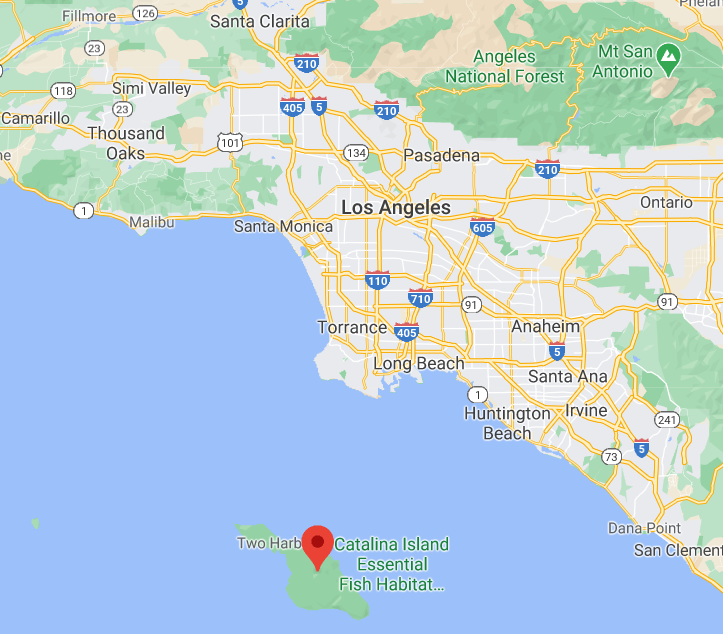

Although it was considered a "neighborhood" "within" Los Angeles, we decided to exclude it since it wasn't subject to the same conditions as all the other Airbnbs in LA would be. The Airbnbs are more exclusive, and visitors can only choose from a limited number of places to stay at.

Consequently, we decided to drop these 20 records from our table. For confirmation, here is the number of related records to Catalina Island from our original dataset.


In [ ]:
listings_df[listings_df['neighbourhood_cleansed'].str.contains('Catalina')]['id'].count()

20

Next, we'll merge the new dataset containing both listings and income data with the crime data as a final step. Since we have crime data at the borough level, we merge on that.

To handle any missing crime per capita data, we fill it in with the median crime per capita rate. Again, we want to minimize the impact of outliers on our rates.

Finally, we drop irrelevant columns and obtain our final LA listings dataset.

In [ ]:
def merge_la_crime(listing_la, la_crime):
  '''
  Merge LA crime data with listing df 

  For neighborhood missing from crime dataset, crime data will be imputed with median

  returns: listing df with la crime data
  '''

  listing_la_merged = listing_la.merge(la_crime, how='left', left_on='neighbourhood_cleansed', right_on = 'neighborhood')
  # replace missing value with median
  med_crime = listing_la_merged.crime_per_capita.median()
  listing_la_merged['crime_per_capita'] = listing_la_merged['crime_per_capita'].fillna(med_crime)
  listing_la_merged.drop(columns=['neighborhood'], inplace=True)

  return listing_la_merged

In [ ]:
listings_la = merge_la_crime(listings_la, la_crime)

Taking a look at the final listings data for LA, we can see that we have successfully added crime_per_capita and income data.

In [ ]:
listings_la.head(5)

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,income,crime_per_capita
0,109,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi Paolo, MIT MBA (P...",None,NaN,0.00,0,1.0,1,1,Culver City,Other Cities,33.98209,-118.38494,Entire home/apt,6,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",115.0,30,2,2011-08-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,LA,88512.142857,17.1
1,32963,The Zanja Shangri-La,"Step back in time in this sleek, recently reno...",The place is just around the corner from the p...,Spencer,2010-06-11,"Los Angeles, California, United States",I'm a traveller myself and have been the benef...,within an hour,1.0,0.94,1,5.0,1,1,Culver City,Other Cities,33.99335,-118.44387,Entire home/apt,4,2.0,2.0,"[""Hair dryer"", ""Garden or backyard"", ""Bedroom ...",175.0,2,133,2011-08-01,98.0,10.0,10.0,10.0,10.0,10.0,9.0,LA,88512.142857,17.1
2,46858,3 Bed Designer House - Fire Pit Lounge & Hot Tub,California living at it's finest in a stellar ...,None,Brenna,2010-08-23,"Culver City, California, United States","From LA, we like to travel, spend time outdoor...",within an hour,1.0,0.92,1,2.0,1,1,Culver City,Other Cities,34.01277,-118.40830,Entire home/apt,6,3.0,3.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",275.0,4,138,2011-02-25,97.0,10.0,10.0,10.0,10.0,10.0,10.0,LA,88512.142857,17.1
3,47794,One Bedroom in Venice/MarinadelRey,private bedroom can sleep 1-2. shared bathroo...,"quiet, peaceful street just off main road...ve...",Rebecca,2010-08-30,"Los Angeles, California, United States",None,None,NaN,NaN,0,1.0,1,0,Culver City,Other Cities,33.99355,-118.44284,Private room,2,1.0,1.0,"[""Free parking on premises"", ""Kitchen"", ""Washe...",100.0,2,3,2014-11-09,100.0,10.0,10.0,10.0,10.0,10.0,9.0,LA,88512.142857,17.1
4,67089,Tranquil Guesthouse Oasis with a Hot Tub,Relax in a hammock or hot tub in a secluded ba...,The bungalow sits behind the main house down t...,Brenna,2010-08-23,"Culver City, California, United States","From LA, we like to travel, spend time outdoor...",within an hour,1.0,0.92,1,2.0,1,1,Culver City,Other Cities,34.00959,-118.40954,Entire home/apt,3,1.0,1.0,"[""Hair dryer"", ""Garden or backyard"", ""Bedroom ...",135.0,1,554,2011-01-02,99.0,NaN,NaN,NaN,NaN,NaN,NaN,LA,88512.142857,17.1


In order to make sure the datasets integrated correctly, we have to ensure that no duplicates resulted from the merges and that the number of records still match our expectation of 30,503. Although our original number was 30,523, we dropped 20 records related to Catalina Island. Therefore, as expected, our number of records is 30,503.

In [ ]:
listings_la['id'].count()

30503

## Final Merge of NYC and LA Datasets

After having merged the datasets for each city respectively, we stack the finalized datasets from each and obtain our fully integrated listings dataset.

In [ ]:
listings_merged = listings_nyc.append(listings_la, ignore_index=True)
listings_merged.drop(columns=['neighbourhood_group_cleansed'], inplace=True)

In [ ]:
listings_merged.head(5)

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,crime_per_capita,income
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,0.70,0.25,0,6.0,1,1,Midtown,40.75362,-73.98377,Entire home/apt,2,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC,0.069784,120248.0
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,within an hour,0.98,0.96,0,1.0,1,1,Clinton Hill,40.68514,-73.95976,Entire home/apt,3,1.0,3.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",76.0,1,354,2014-09-30,89.0,8.0,9.0,9.0,9.0,9.0,9.0,NYC,0.050543,79180.0
2,5121,BlissArtsSpace!,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,None,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",None,NaN,1.00,0,1.0,1,1,Bedford-Stuyvesant,40.68688,-73.95596,Private room,2,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Heating"", ""Kitch...",60.0,29,50,2009-05-28,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NYC,0.050543,79180.0
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,None,Rebecca,2009-02-03,"New York, New York, United States","Rebecca is an artist/designer, and Henoch is i...",within a few hours,1.00,NaN,0,1.0,1,0,Sunset Park,40.66120,-73.99423,Entire home/apt,4,2.0,2.0,"[""Wifi"", ""Dryer"", ""Air conditioning"", ""Kitchen...",175.0,7,1,2014-01-02,97.0,10.0,10.0,10.0,10.0,8.0,10.0,NYC,0.050543,67871.0
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,2009-03-03,"New York, New York, United States",I used to work for a financial industry but no...,within a few hours,1.00,1.00,0,1.0,1,0,Hell's Kitchen,40.76489,-73.98493,Private room,2,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Paid ...",73.0,2,473,2009-05-06,84.0,9.0,7.0,9.0,9.0,10.0,9.0,NYC,0.069784,79180.0


As a final check, we ensure that the number of records still match the original number of 75,172 minus 20 related to Catalina Island that were removed. Here, we can see that it does.

In [ ]:
listings_merged['id'].count()

75152

## Exploration of Integrated Dataset

Since our dataset is finally integrated, we'll take one more look to see if we could learn anything interesting for our models.

We are curious whether there are systematic differences between listing prices in different neighborhoods and, if there are, what the drivers are behind these differences. We have integrated neighborhood level income and crime data with our listing data, and will explore the relationship between neighborhood characteristics below. 

We understand it would be ideal if we could observe the relationship between neighborhood income and listing price directly. But ***neighborhood*** is a discrete feature, which means the income values we collected was also discrete. So now we'll compare the dynamics of each feature against price separately. 

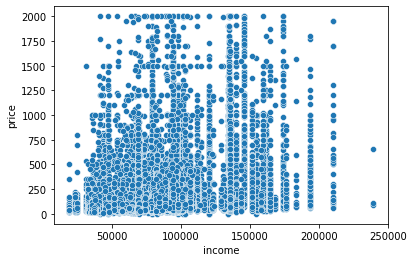

In [ ]:
sns.scatterplot(data=listings_merged[listings_merged.price <= 2000], x='income', y='price')
plt.show()

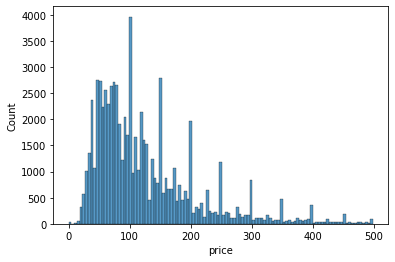

In [ ]:
sns.histplot(data=listings_merged[listings_merged.price<500], x='price')

# Feature Engineering

Now that our dataset is ready to go, it's time to extract some features and prepare our dataset for our models.

Although we'll extract a number of features, we won't be using all of them for all of our models. Depending on the problem we are looking to solve, we will keep specific features and drop others.

We'll create a copy of our dataset for us to manipulate and prep for our models.

In [ ]:
listings_feat_df = listings_merged.copy()

## Standardize Income

Since income will be one of the features we factor into our models, we need to standardize it to ensure consistency.

In [ ]:
scaler = StandardScaler()
scaler.fit(np.array(listings_feat_df['income']).reshape(-1,1))
listings_feat_df['income']=scaler.transform(np.array(listings_feat_df['income']).reshape(-1,1))

## Encode Dates

Since dates in itself isn't a particularly useful feature, we'll also transform these columns into more meaningful features. We will take host_since and first_review and calculate the number of days that has passed since then as of the latest date within the dataset, so that the minimum of the transformed feature would be 0. Since we wanted to keep the days within the scope of the dataset, we decided against using an arbitrary date such as December 31, 2020 as our cutoff date.

In [ ]:
listings_feat_df['days_since_host'] = (max(listings_feat_df['host_since']) - listings_feat_df['host_since']).apply(lambda x: x.days)
listings_feat_df['days_since_firstreview'] = (max(listings_feat_df['first_review']) - listings_feat_df['first_review']).apply(lambda x: x.days)

listings_feat_df.drop(columns = ['host_since', 'first_review'], inplace=True)

## Impute Missing Values

Another issue we have to handle are missing values in *numeric* columns -- we can't leave them blank for our models. Similar to our approach from earlier, we'll fill them in with median values.

We can pinpoint the columns with null values as shown below.

**Note**: We will not be filling in the nulls for any of the review score columns. These ratings are integral drivers of our analyses and predictions, so we do not want to alter them without looking at them more closely.

In [ ]:
listings_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75152 entries, 0 to 75151
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           75152 non-null  int64  
 1   name                         75134 non-null  object 
 2   description                  75152 non-null  object 
 3   neighborhood_overview        75152 non-null  object 
 4   host_name                    75152 non-null  object 
 5   host_location                74945 non-null  object 
 6   host_about                   75152 non-null  object 
 7   host_response_time           44030 non-null  object 
 8   host_response_rate           44030 non-null  float64
 9   host_acceptance_rate         52125 non-null  float64
 10  host_is_superhost            75152 non-null  int64  
 11  host_listings_count          75152 non-null  float64
 12  host_has_profile_pic         75152 non-null  int64  
 13  host_identity_ve

From above, we can see that only 'bedrooms' and 'beds' are the only numeric columns with nulls (excluding the review scores). We'll fill them in with the median, again to avoid unwanted influence form outliers.

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(listings_feat_df[['bedrooms','beds','host_response_rate']])
listings_feat_df[['bedrooms','beds','host_response_rate']] = imp.transform(listings_feat_df[['bedrooms','beds','host_response_rate']])

To double-check, we can see that no nulls exist in those columns anymore.

In [ ]:
listings_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75152 entries, 0 to 75151
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           75152 non-null  int64  
 1   name                         75134 non-null  object 
 2   description                  75152 non-null  object 
 3   neighborhood_overview        75152 non-null  object 
 4   host_name                    75152 non-null  object 
 5   host_location                74945 non-null  object 
 6   host_about                   75152 non-null  object 
 7   host_response_time           44030 non-null  object 
 8   host_response_rate           75152 non-null  float64
 9   host_acceptance_rate         52125 non-null  float64
 10  host_is_superhost            75152 non-null  int64  
 11  host_listings_count          75152 non-null  float64
 12  host_has_profile_pic         75152 non-null  int64  
 13  host_identity_ve

## Encode Categorical Variables 

There are a number of categorical variables that need to be one-hot encoded so our models can properly interpret and use them.

In [ ]:
listings_feat_df.reset_index(inplace=True)

### Host Response Time and Room Type

Both host_response_time and room_type are basic categorical variables that we need to encode since both may have an impact on price and/or ratings. The number of categories associated with each is few, so we can automatically encode each category into its own column.

In [ ]:
host_response_time=pd.get_dummies(listings_feat_df['host_response_time']).reset_index()
listings_feat_df=listings_feat_df.merge(host_response_time,left_on='index',right_on='index')

In [ ]:
room_type=pd.get_dummies(listings_feat_df['room_type']).reset_index()
listings_feat_df=listings_feat_df.merge(room_type,left_on='index',right_on='index')

### Amenities

Amenities are also factors that may impact the price of an Airbnb or quality of reviews. However, simply encoding them is not feasible (or particularly useful) for two reasons:

*   Amenities are stored as a list of varying size within a single column.
*   Hosts can manually add their own specific amenity, which lead to hundreds of amenities to consider and therefore potentially hundreds of features to add to our dataframe.

Instead of adding every single amenity to our feature space, we selected the most popular 20 amenities and encoded those.

First, we obtained the full list of amenities.

In [ ]:
amenities = {}
for i in range(len(listings_feat_df)):
  am=listings_feat_df['amenities'][i].replace('"','').replace('[','').replace(']','').lower().split(',')
  for j in range(len(am)):
    if am[j].strip() not in amenities.keys():
      amenities[am[j].strip()] = 1
    else:
      amenities[am[j].strip()] += 1

Then, out of the full list, we identified the top 20 amenities, displayed below.

In [ ]:
# Get the top 20 most common amenities
top_amenities = Counter(amenities).most_common(20)
top_amenities = [x[0] for x in top_amenities]

In [ ]:
top_amenities

['wifi',
 'essentials',
 'heating',
 'smoke alarm',
 'kitchen',
 'air conditioning',
 'hangers',
 'carbon monoxide alarm',
 'tv',
 'shampoo',
 'hair dryer',
 'laptop-friendly workspace',
 'iron',
 'hot water',
 'washer',
 'dryer',
 'refrigerator',
 'dishes and silverware',
 'fire extinguisher',
 'microwave']

We then created columns out of these 20 and one-hot encoded them.

**Note**: We iteratively encoded these because using any other more elegant solution induced Colab to error out and insist that we upgrade to Colab Pro.

In [ ]:
# Insert top 20 amenities as columns
for i in top_amenities:
  listings_feat_df.insert(len(listings_feat_df.columns), i, [0]*len(listings_feat_df), True) 

In [ ]:
# Iterative one-hot encoding
for i in range(len(listings_feat_df)):
  amenities=listings_feat_df['amenities'][i].replace('"','').replace('[','').replace(']','').lower().split(',')
  for j in range(len(amenities)):
    amenity = amenities[j].strip()
    if amenity in top_amenities:
      listings_feat_df[amenity][i] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
listings_feat_df.drop(columns={'index','host_response_time','amenities','room_type'},inplace=True)
listings_feat_df.head(5)

,id,name,description,neighborhood_overview,host_name,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,crime_per_capita,income,days_since_host,days_since_firstreview,a few days or more,within a day,within a few hours,within an hour,Entire home/apt,Hotel room,Private room,Shared room,wifi,essentials,heating,smoke alarm,kitchen,air conditioning,hangers,carbon monoxide alarm,tv,shampoo,hair dryer,laptop-friendly workspace,iron,hot water,washer,dryer,refrigerator,dishes and silverware,fire extinguisher,microwave
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,0.70,0.25,0,6.0,1,1,Midtown,40.75362,-73.98377,2,1.0,1.0,175.0,3,48,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC,0.069784,1.300252,4427,3990.0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,0
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,0.98,0.96,0,1.0,1,1,Clinton Hill,40.68514,-73.95976,3,1.0,3.0,76.0,1,354,89.0,8.0,9.0,9.0,9.0,9.0,9.0,NYC,0.050543,-0.119423,4338,2216.0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
2,5121,BlissArtsSpace!,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,None,Garon,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",1.00,1.00,0,1.0,1,1,Bedford-Stuyvesant,40.68688,-73.95596,2,1.0,1.0,60.0,29,50,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NYC,0.050543,-0.119423,4280,4167.0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,None,Rebecca,"New York, New York, United States","Rebecca is an artist/designer, and Henoch is i...",1.00,NaN,0,1.0,1,0,Sunset Park,40.66120,-73.99423,4,2.0,2.0,175.0,7,1,97.0,10.0,10.0,10.0,10.0,8.0,10.0,NYC,0.050543,-0.510362,4280,2487.0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,"New York, New York, United States",I used to work for a financial industry but no...,1.00,1.00,0,1.0,1,0,Hell's Kitchen,40.76489,-73.98493,2,1.0,1.0,73.0,2,473,84.0,9.0,7.0,9.0,9.0,10.0,9.0,NYC,0.069784,-0.119423,4252,4189.0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,0,1,0,0,1


<a name="tfidf"></a>
## TF-IDF Encoding

Since we have a number of text columns, we also wanted to extract meaningful information from them. We decided to use TF-IDF to evaluate how relevant certain words are in a given column and how impactful they may be on the price or reviews of a listing.

We'll first visualize the term frequencies across descriptions to get a sense of what we're working with.

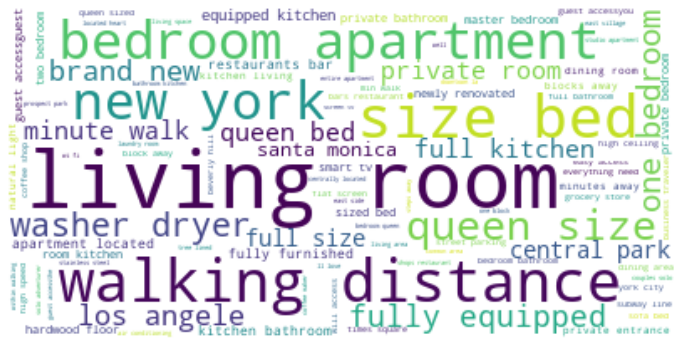

In [ ]:
list_descriptions = listings_feat_df.description.apply(lambda x: x.lower() if isinstance(x, str) else '' )

list_descriptions = ' '.join(t for t in list_descriptions)

stopwords = set(STOPWORDS)
desc_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(list_descriptions)

plt.figure(figsize=(12,8))
plt.imshow(desc_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It's apparent that many descriptions, well, describe the listing! It's interesting to see that "walking distance" is also used very frequently.

We'll break it out by city as well to see if there are any obvious differences aside from mentions of certain locations within each city.

In [ ]:
list_desc_nyc = listings_feat_df[listings_feat_df['city'] == 'NYC'].description.apply(lambda x: x.lower() if isinstance(x, str) else '' )
list_desc_la = listings_feat_df[listings_feat_df['city'] == 'LA'].description.apply(lambda x: x.lower() if isinstance(x, str) else '' )

list_desc_nyc = ' '.join(t for t in list_desc_nyc)
list_desc_la = ' '.join(t for t in list_desc_la)

In [ ]:
stopwords = set(STOPWORDS)
nyc_desc_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(list_desc_nyc)
la_desc_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(list_desc_la)

Comparing the two cities, it is very evident that "living room" appears the most between the two.

Looking at other terms though, we can see that "walking distance" appears more in LA listing descriptions compared to NYC, whereas in the NYC wordcloud, "bedroom apartment" appears quite frequently, but the term does not even appear in the LA wordcloud.

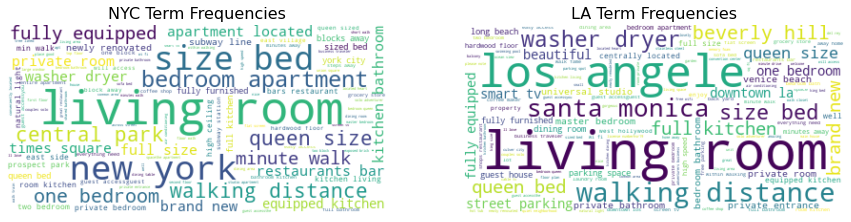

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(nyc_desc_wordcloud, interpolation='bilinear')
ax[1].imshow(la_desc_wordcloud, interpolation='bilinear')
ax[0].set_title("NYC Term Frequencies",fontsize=16)
ax[1].set_title("LA Term Frequencies",fontsize=16)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

Because we have a number of textual columns that we might want to use in our models, we created a function that will extract the TF-IDF score of each row and return them given the train and test datasets (X_train/X_test), column name (var) and maximum number of features to extract (max_features).

Since we'll want to run models with and without these features, we will not extract them here. They will be used later in the **Modeling** section.

In [ ]:
def tfidf_preprocess(X_train, X_test, var, max_features):
  '''
  Fit TF-IDF vectorizer on training data, 
  and transform, return both training and test
  on the specified variable `var'

  returns: train_tokens, test_tokens
  '''
  desc_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features = max_features, token_pattern=r'[a-zA-Z]+')

  train_tokens = desc_vectorizer.fit_transform(X_train[var]).todense()
  test_tokens = desc_vectorizer.transform(X_test[var]).todense()

  return train_tokens, test_tokens

## Sentiment Analysis

In addition to quantifying the importance of words in a given description, we also want to quantify the sentiments. Given a paragraph, how positive, neutral or negative is it and what impact might this have on guests' perceptions and considerations?

The three descriptions that we will extract sentiment scores from are as follows:
* Neighborhood overview: Describes the neighborhood in which the listing is located.
* Description: Describes the actual listing itself.
* Host "About": Provides some background on the host of the listing.

Note that all three of these columns are provided by the host themselves. Therefore, we expect that hosts will make them as positive as possible to attract guests.

In [ ]:
listings_sentiment_df = listings_merged[['id','name','description','neighborhood_overview','host_name','host_about','city']].copy()

### Initial Functions

We'll begin by introducing all the helper functions that we'll need to run the sentiment analysis across the three columns.

Given a paragraph, the *sent_tokenize_content()* function will analyze the sentiment of each sentence within the paragraph and return an average compound score for the whole paragraph, which indicates just how positive (1), negative (-1) or neutral (0) a paragraph is. 

In [ ]:
def sent_tokenize_content(content):
  sid = SentimentIntensityAnalyzer()
  com = []

  sentences = tokenize.sent_tokenize(content)
  for i in range(len(sentences)):
    scores = sid.polarity_scores(sentences[i])
    com.append(scores['compound'])

  return np.mean(com)

The *tokenize_content()* function takes in a string of words and extracts tokens from it. Stopwords such as "a", "the", etc. are removed before the tokens are returned.

In [ ]:
def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  tokens = [x.lower() for x in tokens if x.isalpha() == True]
  tokens = [i for i in tokens if (i in stopwords) == False]

  return tokens

After a string is tokenized, we can use the *get_most_common()* function to count the number of words between two sentences, highest and lowest, and return the differences between the two as counters.

In [ ]:
def get_most_common(highest,lowest):
  # Tokenize and flatten the descriptions
  highest_tokens = [tokenize_content(i) for i in highest]
  highest_tokens = [j for i in highest_tokens for j in i]

  lowest_tokens = [tokenize_content(i) for i in lowest]
  lowest_tokens = [j for i in lowest_tokens for j in i]

  # Keep a running tally of the number of times a given word appears
  highest_counter = Counter()
  for word in highest_tokens:
      highest_counter[word] += 1

  lowest_counter = Counter()
  for word in lowest_tokens:
      lowest_counter[word] += 1

  # Obtain the difference between counters
  difference_highest_counter = highest_counter - lowest_counter
  difference_lowest_counter = lowest_counter - highest_counter

  return difference_highest_counter, difference_lowest_counter

### Extract Sentiment Scores

Using the *sent_tokenize_content()* method above, we will calculate the average compound score of each attribute for each listing.

In [ ]:
listings_sentiment_df['nh_com'] = listings_sentiment_df['neighborhood_overview'].apply(lambda x: sent_tokenize_content(x))

In [ ]:
listings_sentiment_df['desc_com'] = listings_sentiment_df['description'].apply(lambda x: sent_tokenize_content(x))

In [ ]:
listings_sentiment_df['host_com'] = listings_sentiment_df['host_about'].apply(lambda x: sent_tokenize_content(x))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Let's compare the scores to one another. It's pretty evident that the majority of hosts are really good about writing their descriptions with a positive spin, but for some hosts, there is definitely room for improvement. Out of the three, you would think that hosts would write more positively about themselves, but it's interesting to see that this is not necessarily the case.

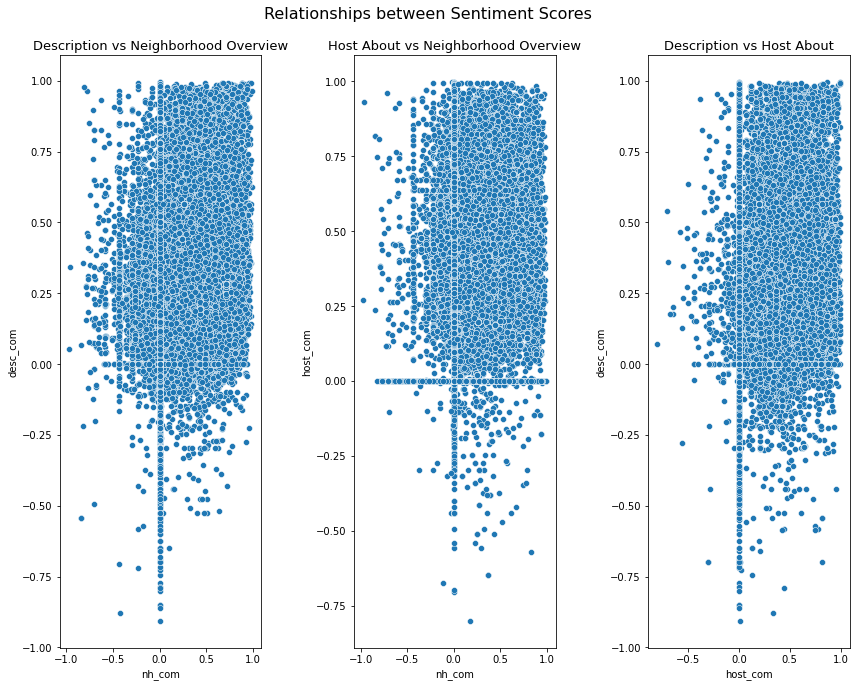

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,10))
sns.scatterplot(data=listings_sentiment_df, x='nh_com',y='desc_com',ax=ax[0])
sns.scatterplot(data=listings_sentiment_df, x='nh_com',y='host_com',ax=ax[1])
sns.scatterplot(data=listings_sentiment_df, x='host_com',y='desc_com',ax=ax[2])
fig.suptitle('Relationships between Sentiment Scores',fontsize=16)
ax[0].set_title('Description vs Neighborhood Overview', fontsize=13)
ax[1].set_title('Host About vs Neighborhood Overview', fontsize=13)
ax[2].set_title('Description vs Host About', fontsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

Let's break the analysis out by city, with NYC on the left-hand side and LA on the right-hand side.

There aren't any really stark differences, but it does seem like LA sentiment scores are less variable and more concentrated in the upper right-hand quadrant, which indicates that both scores are positive.

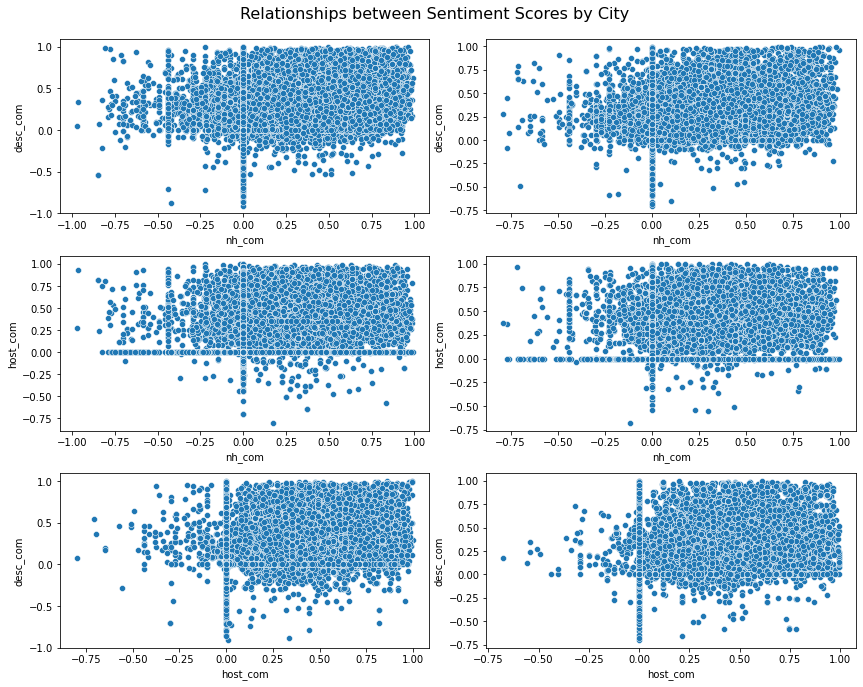

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(12,10))
sns.scatterplot(data=listings_sentiment_df[listings_sentiment_df.city == 'NYC'], x='nh_com',y='desc_com',ax=ax[0][0])
sns.scatterplot(data=listings_sentiment_df[listings_sentiment_df.city == 'NYC'], x='nh_com',y='host_com',ax=ax[1][0])
sns.scatterplot(data=listings_sentiment_df[listings_sentiment_df.city == 'NYC'], x='host_com',y='desc_com',ax=ax[2][0])
sns.scatterplot(data=listings_sentiment_df[listings_sentiment_df.city == 'LA'], x='nh_com',y='desc_com',ax=ax[0][1])
sns.scatterplot(data=listings_sentiment_df[listings_sentiment_df.city == 'LA'], x='nh_com',y='host_com',ax=ax[1][1])
sns.scatterplot(data=listings_sentiment_df[listings_sentiment_df.city == 'LA'], x='host_com',y='desc_com',ax=ax[2][1])
fig.suptitle('Relationships between Sentiment Scores by City',fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

### Token Analysis

Next, we'll take a closer look at each of the three descriptive columns and try to identify any notable differences between highly-rated Airbnbs and "poorly" rated ones (classified as listings with review scores of less than 80%).

In [ ]:
highest_df = listings_df[listings_df.review_scores_rating >= 80][['neighborhood_overview','description','host_about']]
lowest_df = listings_df[listings_df.review_scores_rating < 80][['neighborhood_overview','description','host_about']]

*Neighborhood Overview*

First, we'll see what percentage of hosts actually filled out the neighborhood overview description for their listing.

The different is obvious: 71% of hosts of highly rated Airbnbs filled out this description as opposed to only 53% of poorly rated Airbnbs.

In [ ]:
highest_df[highest_df.neighborhood_overview != 'None']['neighborhood_overview'].count()/highest_df.count()['neighborhood_overview']

0.7063403169240374

In [ ]:
lowest_df[lowest_df.neighborhood_overview != 'None']['neighborhood_overview'].count()/lowest_df.count()['neighborhood_overview']

0.5319980459208598

Since the number of poorly rated Airbnbs is already low (about 2k compared to the 38k for highly rated), we'll have to be cautious when analyzing the most common terms generated from poorly rated listings.

In [ ]:
highest_desc = list(highest_df['neighborhood_overview'])
lowest_desc = list(lowest_df['neighborhood_overview'])

highest_nh_counter, lowest_nh_counter = get_most_common(highest_desc,lowest_desc)

highest_wordcloud = WordCloud().generate_from_frequencies(highest_nh_counter)
lowest_wordcloud = WordCloud().generate_from_frequencies(lowest_nh_counter)

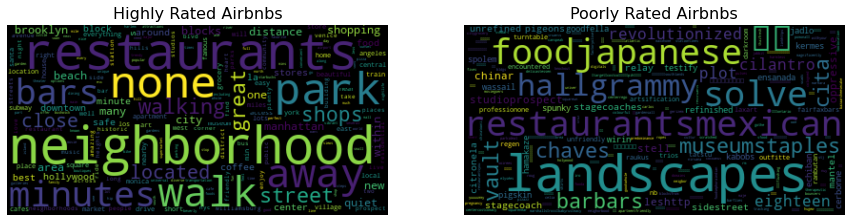

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(highest_wordcloud, interpolation='bilinear')
ax[1].imshow(lowest_wordcloud, interpolation='bilinear')
ax[0].set_title("Highly Rated Airbnbs",fontsize=16)
ax[1].set_title("Poorly Rated Airbnbs",fontsize=16)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

*Description*

Similarly, we'll run the same analysis for 'description' which is where the host describes the listing. Compared to neighborhood overview, it is extremely apparent that hosts of all Airbnbs realize this is important.

Still though, it is worth noting that hosts of highly rated Airbnbs still have a better completion rate.

In [ ]:
highest_df[highest_df.description != 'None']['description'].count()/highest_df.count()['description']

0.9845577569269752

In [ ]:
lowest_df[lowest_df.description != 'None']['description'].count()/lowest_df.count()['description']

0.9555446995603322

In [ ]:
highest_desc = list(highest_df['description'])
lowest_desc = list(lowest_df['description'])

highest_desc_counter, lowest_desc_counter = get_most_common(highest_desc,lowest_desc)

highest_wordcloud = WordCloud().generate_from_frequencies(highest_desc_counter)
lowest_wordcloud = WordCloud().generate_from_frequencies(lowest_desc_counter)

The results of this analysis is more striking. By looking at the word cloud for highly rated listings, we can see that the biggest words do indeed describe a listing. However, when looking at the cloud for poorly rated listings, we can see that there are misspellings and many other words that seem unrelated to describing a dwelling.

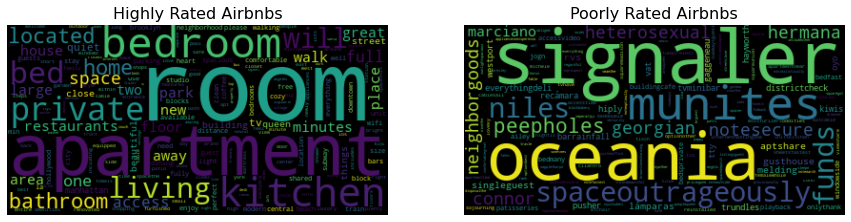

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(highest_wordcloud, interpolation='bilinear')
ax[1].imshow(lowest_wordcloud, interpolation='bilinear')
ax[0].set_title("Highly Rated Airbnbs",fontsize=16)
ax[1].set_title("Poorly Rated Airbnbs",fontsize=16)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

*Host About*

More closely aligned with how hosts perceive the importance of filling out neighborhood overview, we can also see that hosts from both sides also don't think providing a description about themselves is important.

In [ ]:
highest_df[highest_df.host_about != 'None']['host_about'].count()/highest_df.count()['host_about']

0.6585997319182534

In [ ]:
lowest_df[lowest_df.host_about != 'None']['host_about'].count()/lowest_df.count()['host_about']

0.5246702491450904

In [ ]:
highest_desc = list(highest_df['host_about'])
lowest_desc = list(lowest_df['host_about'])

highest_host_counter, lowest_host_counter = get_most_common(highest_desc,lowest_desc)

highest_wordcloud = WordCloud().generate_from_frequencies(highest_host_counter)
lowest_wordcloud = WordCloud().generate_from_frequencies(lowest_host_counter)

Again, we can see the dichotomy between the two. For more highly rated listings, the words do generally convey positive feelings. Poorly rated listings on the other hand seem to use words that don't really have a positive or negative connotation (except 'delighting').

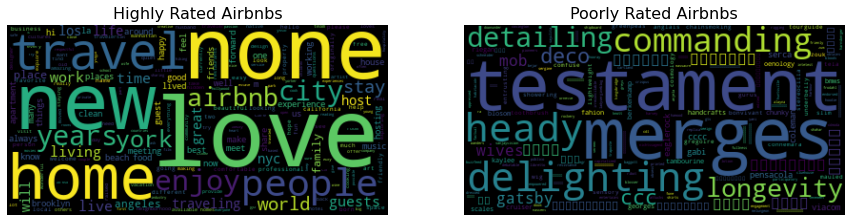

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(highest_wordcloud, interpolation='bilinear')
ax[1].imshow(lowest_wordcloud, interpolation='bilinear')
ax[0].set_title("Highly Rated Airbnbs",fontsize=16)
ax[1].set_title("Poorly Rated Airbnbs",fontsize=16)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

## Commonality of Host Names

Finally, the last features we will extract will help us assess any biases that guests may have.

We use the corpus of names from nltk to classify host names. Using this approach, if the host name is in the corpus:

1.   We can assume it is relatively common.
2.   We can obtain the gender of the name.

If a name does not exist in the corpus, we assume that it is generally uncommon and we attempt to infer the gender based on whether the name ends in an 'a' or  'o'. No other attempts at inference are made since doing so might inject our own biases and perceptions of names.

First, we'll obtain the corpus of presumably common male and female names from nltk and standardize capitalization for our analysis.

In [ ]:
male_names = names.words('male.txt')
female_names = names.words('female.txt')

male_names = [name.lower() for name in male_names]
female_names = [name.lower() for name in female_names]

We'll also create two helper functions to better streamline our analysis.

The *get_gender()* function retrieves the gender of a name if the name is common (i.e. in the nltk corpus).

In [ ]:
def get_gender(names):
  if any(x.isupper() for x in names):
    names = re.findall('[A-Z][^A-Z]*',names)  # There are some names concatenated together that need filtering out
  names = [name.lower() for name in names]
  for name in names:
    if name in male_names:
      return 0
    elif name in female_names:
      return 1
  return -1

We also create another function, *infer_gender()*, that will only be used on names that do not appear in the corpus. We will infer that a name is female if it ends in an 'a' or male if it ends in an 'o'.


In [ ]:
def infer_gender(name):
  if name[-1] == 'a':
    return 1
  elif name[-1] == 'o':
    return 0
  else:
    return -1

Now we'll begin our analysis. Since host names aren't as straightforward as you would think, we took a number of steps to account for as many "types" of names as possible.

We'll begin by just classifying as many names as we can without any tampering.

In [ ]:
listings_sentiment_df['gender'] = listings_sentiment_df['host_name'].apply(lambda x: get_gender(x))

Then, there are also many instances where multiple names or words are concatenated together. In this step, we'll break the names up into a list and classify the gender based on the first name that can be found in the corpus.

In [ ]:
listings_sentiment_df['first_gender'] = listings_sentiment_df['host_name'].apply(lambda x: get_gender(x.lower().split()))

We then combine the two. If a name wasn't originally classified in the first pass, we will classify the gender using the second method.

In [ ]:
listings_sentiment_df['gender'] = np.where(listings_sentiment_df['gender']==-1, listings_sentiment_df['first_gender'],listings_sentiment_df['gender'])

The two methods both compare names against the corpus. Therefore, any name that has been successfully as male (0) or female (1) will be considered to be common names.

In [ ]:
listings_sentiment_df['isCommon'] = listings_sentiment_df['gender'].apply(lambda x: 0 if x==-1 else 1)

Now things get a bit hazier. We can see that a fair number of names are still unclassified. We will attempt to account for more of them by classifying names as female if they end in an 'a' or male if they end in an 'o'.

We will only use this inferred gender for names that are marked as uncommon.

In [ ]:
listings_sentiment_df['gender'].value_counts()

 0    29703
 1    24970
-1    20479
Name: gender, dtype: int64

In [ ]:
listings_sentiment_df['inferred_gender'] = listings_sentiment_df['host_name'].apply(lambda x: infer_gender(x.lower()))

In [ ]:
listings_sentiment_df['gender'] = np.where(listings_sentiment_df['isCommon']==0, listings_sentiment_df['inferred_gender'], listings_sentiment_df['gender'])

While a majority of the names have been classified now, we can still see a significant number of them have not. To avoid injecting our own biases, we will leave them unclassified. The names with no gender (-1) will be marked as uncommon, and we hope that the two features together will provide some insight on what implicit biases a potential guest might have when viewing a listing.

In [ ]:
listings_sentiment_df['gender'].value_counts()

 0    30815
 1    28805
-1    15532
Name: gender, dtype: int64

To avoid printing thousands of names, we will only display a snapshot here. They do indeed seem uncommon.

In [ ]:
print(listings_sentiment_df[listings_sentiment_df['gender'] == -1]['host_name'].unique())

['Garon' 'Shunichi' 'Cyn' ... 'Xiaonan' 'Haile' 'Heyly']


We'll now finalize our NLP dataset (including features from both the Sentiment Analysis and Host Names Analysis) by dropping intermediate columns and taking a look.

In [ ]:
listings_sentiment_df.drop(columns={'first_gender','inferred_gender'},inplace=True)

In [ ]:
listings_sentiment_df.head(5)

,id,name,description,neighborhood_overview,host_name,host_about,city,nh_com,desc_com,host_com,gender,isCommon
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,A New Yorker since 2000! My passion is creatin...,NYC,0.17610,0.801725,0.432650,1,1
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,Laid-back Native New Yorker (formerly bi-coast...,NYC,0.50435,0.370929,0.136600,1,1
2,5121,BlissArtsSpace!,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,None,Garon,"I am an artist(painter, filmmaker) and curato...",NYC,0.00000,0.270364,0.590133,-1,0
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,None,Rebecca,"Rebecca is an artist/designer, and Henoch is i...",NYC,0.00000,0.309900,0.212300,1,1
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,I used to work for a financial industry but no...,NYC,0.00000,0.151391,0.000000,-1,0


# Modeling

Having finalized our features, we are ready to begin modeling. As mentioned at the beginning, we will predict 1) the price of a given listing and 2) the success of future listings, as measured by the reviews/ratings.

Since our two goals will necessitate different features, we created a function that will drop columns depending on the type of analysis (either 'price' or 'review').

In [ ]:
def drop_cols(listings_df, analysis):
  '''
  Generate a list of columns to drop based on the type of analysis

  analysis - string, 'price' or 'review'

  returns: list
  '''
  cols = pd.Series(listings_df.columns)
  if analysis=='price':
    host_cols = list(cols[cols.apply(lambda x: 'host' in x)])
    other_cols = ['id', 'name', 'neighborhood_overview','neighbourhood_cleansed','latitude','longitude', 'city']
    review_cols = list(cols[cols.apply(lambda x: 'review' in x)])
    drop_cols = host_cols + other_cols +review_cols

  elif analysis=='review':
    review_cols = list(cols[cols.apply(lambda x: ('review_scores' in x) & (x!='review_scores_rating'))])
    other_cols = ['id', 'description', 'name', 'neighborhood_overview','host_name','host_location', 'host_about',
                  'neighbourhood_cleansed', 'host_acceptance_rate','latitude','longitude', 'city']
    drop_cols = review_cols+other_cols

  return drop_cols

Before we begin modeling, let's check for multicollinearity. For the most part, features are not correlated, which is great! There are some obviously correlated features such as latitude/longitude and crime per capita; washers and dryers; and overall review scores vs sub-review scores. However, since we know a number of these are irrelevant and will be dropped during our analysis, we will not run any other dimensionality reduction techniques for our models.

**Note**: We did experiment with PCA to solidify our conclusion; reducing the dimensionality of our sets prior to modeling (such as linear regression) increased our loss.

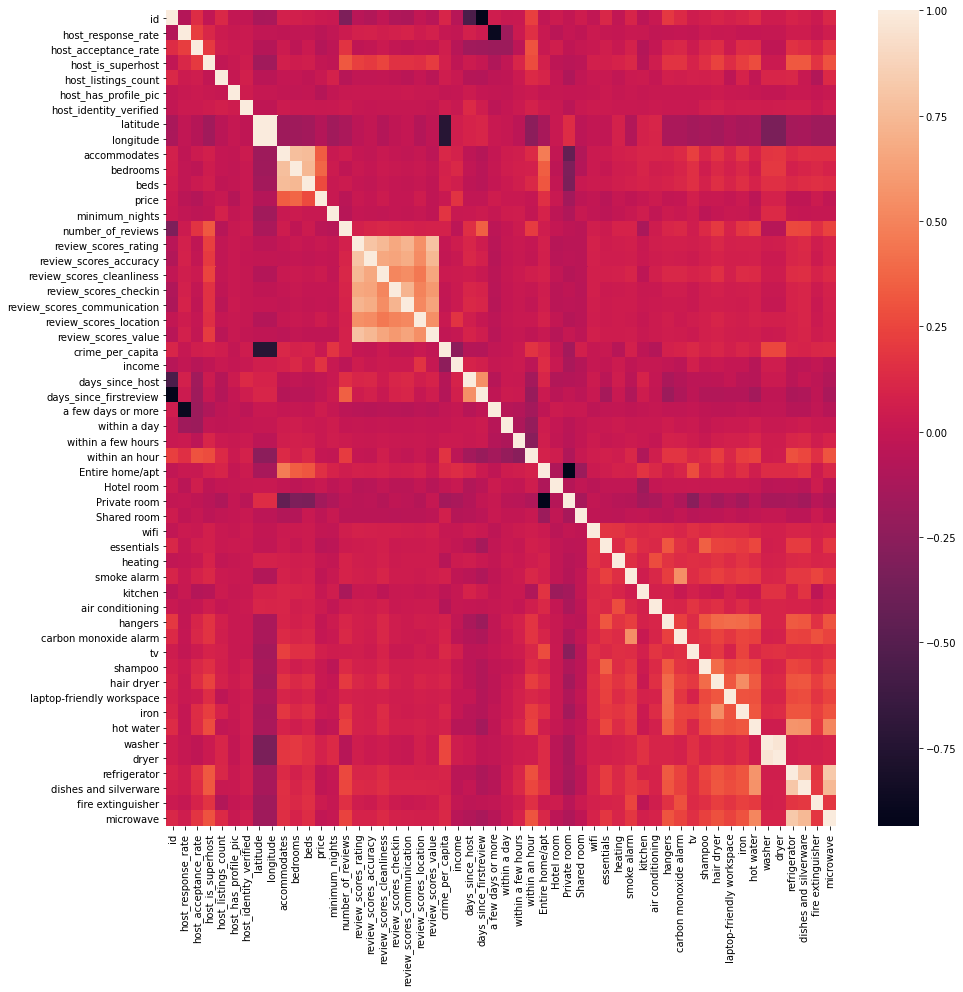

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(listings_feat_df.corr())
plt.show()

## Price Prediction

The first question we will answer is, how accurately can we predict price and what features impact the prediction?

In this section, we will experiment with certain features and obtain meaningful insights into the predictors of Airbnb prices.

### Data Preparation

Before we can run ahead with our models, we need to first ensure we have the appropriate features and datasets. We will drop the following features from our dataset for this analysis:

In [ ]:
drop_price = drop_cols(listings_feat_df,'price')
drop_price

['host_name',
 'host_location',
 'host_about',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'days_since_host',
 'id',
 'name',
 'neighborhood_overview',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'city',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'days_since_firstreview']

In [ ]:
listings_price_df = listings_feat_df.drop(columns=drop_price)

Here's a glance at our data along with the relevant features. Note that we are keeping 'description' for now since we will use it to generate TD-IDF scores later.

In [ ]:
listings_price_df.head(5)

,description,accommodates,bedrooms,beds,price,minimum_nights,crime_per_capita,income,a few days or more,within a day,within a few hours,within an hour,Entire home/apt,Hotel room,Private room,Shared room,wifi,essentials,heating,smoke alarm,kitchen,air conditioning,hangers,carbon monoxide alarm,tv,shampoo,hair dryer,laptop-friendly workspace,iron,hot water,washer,dryer,refrigerator,dishes and silverware,fire extinguisher,microwave
0,"Beautiful, spacious skylit studio in the heart...",2,1.0,1.0,175.0,3,0.069784,1.300252,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,0
1,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",3,1.0,3.0,76.0,1,0.050543,-0.119423,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
2,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,2,1.0,1.0,60.0,29,0.050543,-0.119423,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,We welcome you to stay in our lovely 2 br dupl...,4,2.0,2.0,175.0,7,0.050543,-0.510362,0,0,1,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0
4,Please don’t expect the luxury here just a bas...,2,1.0,1.0,73.0,2,0.069784,-0.119423,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,0,1,0,0,1


Since we're predicting price, we will also remove obvious outliers that may throw off our models by dropping listings with a price of more than \$6,000. Only 102 out of our 75k+ listings are priced at more than $6k.

In [ ]:
listings_price_df[listings_price_df.price > 6000]['accommodates'].count()

102

In [ ]:
listings_price_df = listings_price_df[listings_price_df.price <= 6000]

Next, we'll split our dataset into sets for training and testing, and also split our training set into a separate validation set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(listings_price_df.drop(columns='price'), listings_price_df['price'], random_state=47)

In [ ]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=47)

We'll also retain a copy of our training and test sets to be used later in the [Prediction with Word Features](#predictwords) part of our analysis.

In [ ]:
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

Now we're ready to build our models and predict price.

### Prediction without Word Features

We will begin by predicting price without word features (i.e. without using TF-IDF scores). Our aim here is two-fold:
1. To experiment with different models and identify which performs the best and
2. To conduct a sensitivity analysis of certain features and quantify their impact on our predictions.

In [ ]:
X_train.drop(columns={'description'},inplace=True)
X_test.drop(columns={'description'},inplace=True)
X_t.drop(columns={'description'},inplace=True)
X_val.drop(columns={'description'},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Model Experimentation

The models that we will initially experiment with are Linear Regression, Lasso Regression, Random Forest, k-Nearest Neighbors (KNN), and Neural Networks. Our goal is to pinpoint which model performs the best and use that in our later analyses.

Note that since price isn't discrete, we will measure performance using the mean absolute error (MAE), which will just measure the average magnitude of the errors in our predictions. We will not use metrics such as root mean squared (RMSE) because we want an accurate representation of how far off our predictions are compared to the actual price and bigger differences should not be more heavily penalized.

We will run each model first and calculate the corresponding training and test losses. After all models have been run, an analysis will be provided.

*Linear Regression*

We'll start with the most basic model to be used as our baseline.

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  92.07704928480896
Test loss:  95.23853517466087


Looking at the results of our linear regression, we can see that only about 31% of the variation in the results is attributed to our features. Although this isn't particularly high, it's still significant since almost 1/3 of the variation in price is explained by these features.

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     764.0
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:31:00   Log-Likelihood:            -3.8481e+05
No. Observations:               56287   AIC:                         7.697e+05
Df Residuals:                   56253   BIC:                         7.700e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

*Elastic Net Regression*

Since we believe that there are few significant parameters and that there might be multicollinearity, we decided to also use elastic net regression instead of just lasso or ridge.

In [ ]:
eln = ElasticNet(alpha=1.2)
eln.fit(X_train, y_train)
train_pred = eln.predict(X_train)
test_pred = eln.predict(X_test)
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  87.18733630797789
Test loss:  91.06288877328079


*Random Forest*

Random Forests have the reputation of being highly accurate and also parallelizable, without overfitting to the data.

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=5)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test) 
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  72.5271760067215
Test loss:  77.80346003073385


*K-Nearest Neighbors (KNN)*

For KNN, we ran the model with *k*'s varying from 1 to 15 in order to visualize the impact of increasing the number of neighbors.

From the results below, we will use k=9 in our subsequent analyses.

In [ ]:
train_loss = []
test_loss = []
for k in np.arange(1,15):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, y_train)
  train_pred = knn.predict(X_train)
  test_pred = knn.predict(X_test) 
  test_loss.append(mean_absolute_error(y_test, test_pred))
  print("K: ",k)
  print("Training loss: ", mean_absolute_error(y_train, train_pred))
  print("Test loss: ", mean_absolute_error(y_test, test_pred))

K:  1
Training loss:  2.7927473484108236
Test loss:  89.00772104674093
K:  2
Training loss:  43.38720272887168
Test loss:  82.24224724191227
K:  3
Training loss:  52.93806231160541
Test loss:  80.21006946295013
K:  4
Training loss:  57.7890502691563
Test loss:  78.65192559825188
K:  5
Training loss:  60.41029573436139
Test loss:  77.92666748387784
K:  6
Training loss:  62.28958498409935
Test loss:  77.14536614613868
K:  7
Training loss:  63.71822478674344
Test loss:  76.65938061991305
K:  8
Training loss:  64.7687409837085
Test loss:  76.50229294355913
K:  9
Training loss:  65.80170319572508
Test loss:  76.34412969970451
K:  10
Training loss:  66.55986581270987
Test loss:  76.3258411767841
K:  11
Training loss:  67.17859022832657
Test loss:  76.27740184986894
K:  12
Training loss:  67.62916731809003
Test loss:  76.37683672653627
K:  13
Training loss:  68.10052716093756
Test loss:  76.3544241326014
K:  14
Training loss:  68.47204765627181
Test loss:  76.43026237047076


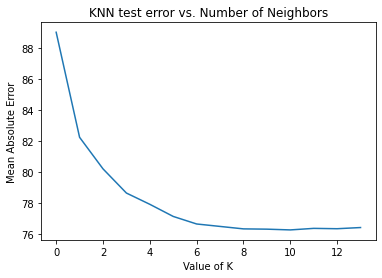

In [ ]:
plt.plot(test_loss, label = 'Test Error')
plt.xlabel('Value of K')
plt.ylabel('Mean Absolute Error')
plt.title('KNN test error vs. Number of Neighbors')
plt.show()

*Neural Network*

To end our analysis, we also built a neural network. While we understand that complex models don't always perform better than simpler models, we built this for comparison purposes.

In [ ]:
X_train_nn = torch.from_numpy(X_t.to_numpy()) 
X_val_nn = torch.from_numpy(X_val.to_numpy())
y_train_nn = torch.from_numpy(y_t.to_numpy().reshape(len(y_t),1))
y_val_nn = torch.from_numpy(y_val.to_numpy().reshape(len(y_val),1))

train_data = data.TensorDataset(X_train_nn, y_train_nn)
trainloader = data.DataLoader(train_data, batch_size = 256, shuffle=True)

val_data = data.TensorDataset(X_val_nn, y_val_nn)

In [ ]:
class Net(nn.Module):
  def __init__(self, n_features, hidden_size):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(n_features, hidden_size)
    self.hidden = nn.Linear(hidden_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.hidden(x))
    x = self.linear2(x)
    
    return x

In [ ]:
net = Net(X_train.shape[1], hidden_size = 20)

criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0008, weight_decay=0.00005)

training_loss = []
validation_loss = []

for epoch in range(15):
  train_loss = []

  for batch in trainloader:
    optimizer.zero_grad()

    y_pred = net(batch[0].float())
    loss = criterion(y_pred, batch[1].float())
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  net.eval()
  print("Epoch", epoch)
  print("Training loss: ", np.mean(train_loss))
  training_loss.append(np.mean(train_loss))
  y_val_pred = net(X_val_nn.float())
  val_loss = criterion(y_val_pred, y_val_nn.float())
  print("Validation loss: ", val_loss.item())
  validation_loss.append(val_loss.item())

Epoch 0
Training loss:  139.64291441946318
Validation loss:  107.17002868652344
Epoch 1
Training loss:  92.89274837609493
Validation loss:  87.96107482910156
Epoch 2
Training loss:  82.0521477207993
Validation loss:  81.83097076416016
Epoch 3
Training loss:  77.07755767359878
Validation loss:  78.39306640625
Epoch 4
Training loss:  75.26074345906575
Validation loss:  77.58303833007812
Epoch 5
Training loss:  74.70748469034831
Validation loss:  77.03955841064453
Epoch 6
Training loss:  74.22770674734404
Validation loss:  76.65885925292969
Epoch 7
Training loss:  73.88662259650953
Validation loss:  76.24813079833984
Epoch 8
Training loss:  73.54505330866033
Validation loss:  75.93546295166016
Epoch 9
Training loss:  73.2462494358872
Validation loss:  75.69686889648438
Epoch 10
Training loss:  72.97448755900065
Validation loss:  75.33241271972656
Epoch 11
Training loss:  72.68502655029297
Validation loss:  75.05936431884766
Epoch 12
Training loss:  72.46880927808357
Validation loss:  74.8

In [ ]:
X_test_nn = torch.from_numpy(X_test.to_numpy()) 
y_test_nn = torch.from_numpy(y_test.to_numpy().reshape(len(y_test),1)) 
y_train_pred = net(X_test_nn.float())
print("Test loss: ", criterion(y_train_pred, y_test_nn).item())

Test loss:  76.32311623109919


**Initial Conclusions**

We noted that Random Forest performed the best, with a test error of about \$72, though it is still pretty high. Random Forest also ran relatively quickly compared to KNN and neural network, so we will use Random Forest in our subsequent analyses.

#### Sensitivity Analysis

We have obtained our initial results using various models, but now we will experiment with our features. What will the results be if certain features are removed?

##### Income and Crime Predictors

We originally pulled crime per capita and income to see what the impact of external factors might be on Airbnbs. In this experiment, we ran the models again, but crime_per_capita and income were *removed*.

In [ ]:
X_train_alt = X_train.drop(columns=['crime_per_capita','income'])
X_test_alt = X_test.drop(columns=['crime_per_capita','income'])

X_t_alt = X_t.drop(columns=['crime_per_capita','income'])
X_val_alt = X_val.drop(columns=['crime_per_capita','income'])

y_t_alt = y_t.drop(columns=['crime_per_capita','income'])
y_val_alt = y_val.drop(columns=['crime_per_capita','income'])

Our model that had previously performed the best, Random Forest, has worsened in performance. The error in price prediction increased by almost \$6. We suspect socioeconomic predictors provided valuable information in a hierarchical way that allows Random Forest to make better informed splits.

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=3)
rf.fit(X_train_alt, y_train)
train_pred = rf.predict(X_train_alt)
test_pred = rf.predict(X_test_alt) 
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  76.19411892850198
Test loss:  83.62620368170904


##### Listings with 3 or Fewer Bedrooms

Earlier, when we were visualizing the relationship between the number of bedrooms and listing price, we noticed that apart from the positive correlation, the variance within a category also increased, i.e. listing prices of 5 bedrooms have higher variance than those of 1 or 2 bedrooms.

Given the data and our experience with Airbnb rentals, most listings have only 3 or fewer bedrooms. Therefore, the following analysis focuses on just the listings within this subset.

**Note**: Income and crime per capita are re-included in this analysis.

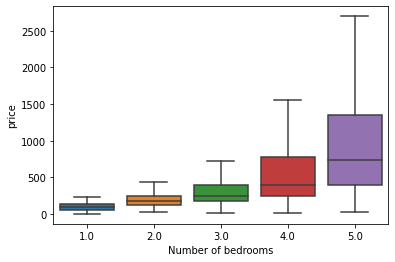

In [ ]:
sns.boxplot(data = listings_price_df[listings_price_df.bedrooms<=5], x='bedrooms', y='price', showfliers=False)
plt.xlabel('Number of bedrooms')
plt.show()

In [ ]:
listings_3bed_df = listings_price_df[listings_price_df.bedrooms <= 3]

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(listings_3bed_df.drop(columns='price'), listings_3bed_df['price'], random_state=47)

In [ ]:
X_train3.drop(columns={'description'},inplace=True)
X_test3.drop(columns={'description'},inplace=True)

We ran the same models as before and it turns out, our models performed significantly better! By reducing in-group variance, our predictions drastically improved.

Using linear regression, our predictions improved by an average of \$25 and using Random Forest, which was already our best model, our predictions improved by \$13.

In [ ]:
lr = LinearRegression()
lr.fit(X_train3, y_train3)
train_pred = lr.predict(X_train3)
test_pred = lr.predict(X_test3)
print("Training loss: ", mean_absolute_error(y_train3, train_pred))
print("Test loss: ", mean_absolute_error(y_test3, test_pred))

Training loss:  68.05529896666307
Test loss:  70.2603677012061


In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=5)
rf.fit(X_train3, y_train3)
train_pred = rf.predict(X_train3)
test_pred = rf.predict(X_test3)
print("Training loss: ", mean_absolute_error(y_train3, train_pred))
print("Test loss: ", mean_absolute_error(y_test3, test_pred))

Training loss:  60.45175323730684
Test loss:  64.3262438759423


<a name="predictwords"></a>
### Prediction with Word Features

We will now pivot and begin predicting price *with* word features (i.e. using TF-IDF scores). Our goal here is to analyze whether a listing's description has any impact on the listing's price.

Using the [TF-IDF function](#tfidf) that we created, we will extract the TF-IDF scores from the descriptions of listings and limit the maximum number of features to 100, and append these to our training and test sets.

In [ ]:
train_desc, test_desc = tfidf_preprocess(X_train_orig, X_test_orig, 'description', 100)

In [ ]:
X_train_np = np.hstack((X_train.values, train_desc))
X_test_np = np.hstack((X_test.values, test_desc))

Let's run our models again and see what we get.

In [ ]:
lr = LinearRegression()
lr.fit(X_train_np, y_train)
train_pred = lr.predict(X_train_np)
test_pred = lr.predict(X_test_np)
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  92.2388274268481
Test loss:  95.13712791214759


In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=5)
rf.fit(X_train_np, y_train)
train_pred = rf.predict(X_train_np)
test_pred = rf.predict(X_test_np) 
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  77.66987252877175
Test loss:  85.13478932623119


In [ ]:
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train_np, y_train)
train_pred = knn.predict(X_train_np)
test_pred = knn.predict(X_test_np) 
test_loss.append(mean_absolute_error(y_test, test_pred))
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  65.41220414028894
Test loss:  76.25033600407421


In comparison to the previous analysis without including word token features, we noticed that the model performances in general either didn't change or worsened. This is interesting since we thought including listing description would provide the model with more information about the listing, which would consequently improve model performance, but this result shows that subjective information such as listing descriptions doesn't seem to affect listing price.

### Conclusion: Price Prediction
Looking at it holistically, our overall results make sense.

Given the multitude of different factors that dictates prices, trying to accurately predict it is in itself an immense challenge. Although our predictions weren't too accurate, we can conclude that neighborhood income and crime per capita are important factors in determining listing prices. Given more time, we would further explore other external factors that we could account for.

Another factor to consider is that listing prices are set by the host. This also adds a twist to our analysis because we don't know how hosts decide what price to set. Do they actually look at surrounding Airbnbs to make their decision? Do they set the price based on how much they would "like" to make? Do they inflate the price because they don't actually want to rent out their place but they could use the money? Without more data that we can leverage to maybe capture this decision-making process, we understand that our errors would be bigger.

**Final Conclusion**: Airbnb listing price is difficult to predict from the data we have because it depends on external factors such as socioeconomic ones, but also on individual host preferences and perceptions. 

## Reviews Prediction

The second question we will answer is, how accurately can we predict reviews/ratings?

In this section, we will experiment with certain features to obtain meaningful insights into the predictors of Airbnb reviews. We expect that this analysis will be inherently different from the price predictions because hosts have more control over making their Airbnb great for guests.

### Data Preparation

Before we can run ahead with our models, we need to first ensure we have the appropriate features and datasets. We'll merge our dataset with the sentiments dataset to obtain the sentiment features.

In [ ]:
listings_review_df = listings_feat_df.merge(listings_sentiment_df[['id','nh_com','desc_com','host_com','gender','isCommon']], left_on='id', right_on='id')

We will drop the following features from our dataset for this analysis:

In [ ]:
drop_review = drop_cols(listings_review_df,'review')
drop_review

['review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'id',
 'description',
 'name',
 'neighborhood_overview',
 'host_name',
 'host_location',
 'host_about',
 'neighbourhood_cleansed',
 'host_acceptance_rate',
 'latitude',
 'longitude',
 'city']

In [ ]:
listings_review_df = listings_review_df.drop(columns=drop_review)

Here's a glance at our data along with the relevant features.

In [ ]:
listings_review_df.head(5)

,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,review_scores_rating,crime_per_capita,income,days_since_host,days_since_firstreview,a few days or more,within a day,within a few hours,within an hour,Entire home/apt,Hotel room,Private room,Shared room,wifi,essentials,heating,smoke alarm,kitchen,air conditioning,hangers,carbon monoxide alarm,tv,shampoo,hair dryer,laptop-friendly workspace,iron,hot water,washer,dryer,refrigerator,dishes and silverware,fire extinguisher,microwave,nh_com,desc_com,host_com,gender,isCommon
0,0.70,0,6.0,1,1,2,1.0,1.0,175.0,3,48,94.0,0.069784,1.300252,4427,3990.0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,0,0.17610,0.801725,0.432650,1,1
1,0.98,0,1.0,1,1,3,1.0,3.0,76.0,1,354,89.0,0.050543,-0.119423,4338,2216.0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0.50435,0.370929,0.136600,1,1
2,1.00,0,1.0,1,1,2,1.0,1.0,60.0,29,50,90.0,0.050543,-0.119423,4280,4167.0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.270364,0.590133,-1,0
3,1.00,0,1.0,1,0,4,2.0,2.0,175.0,7,1,97.0,0.050543,-0.510362,4280,2487.0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0.00000,0.309900,0.212300,1,1
4,1.00,0,1.0,1,0,2,1.0,1.0,73.0,2,473,84.0,0.069784,-0.119423,4252,4189.0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0.00000,0.151391,0.000000,-1,0


Since our goal in this section is to predict reviews, we will also drop the listings that have null scores.

In [ ]:
listings_review_df = listings_review_df[listings_review_df.review_scores_rating.notna()]

Let's double check to make sure we don't have any null values... it looks like we have a handful for host_com, the sentiment scores of host_about. Since there aren't many (71), let's just drop them so we don't skew the data in any way.

In [ ]:
listings_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56493 entries, 0 to 75150
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         56493 non-null  float64
 1   host_is_superhost          56493 non-null  int64  
 2   host_listings_count        56493 non-null  float64
 3   host_has_profile_pic       56493 non-null  int64  
 4   host_identity_verified     56493 non-null  int64  
 5   accommodates               56493 non-null  int64  
 6   bedrooms                   56493 non-null  float64
 7   beds                       56493 non-null  float64
 8   price                      56493 non-null  float64
 9   minimum_nights             56493 non-null  int64  
 10  number_of_reviews          56493 non-null  int64  
 11  review_scores_rating       56493 non-null  float64
 12  crime_per_capita           56493 non-null  float64
 13  income                     56493 non-null  flo

In [ ]:
listings_review_df = listings_review_df[listings_review_df.host_com.notna()]

Next, we'll split our dataset into sets for training and testing, and also split our training set into a separate validation set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(listings_review_df.drop(columns='review_scores_rating'), listings_review_df['review_scores_rating'], random_state=47)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=47)

### Predictions

Using the features specified above, let's first obtain our baselines again before diving more deeply into what might impact reviews.

*Linear Regression*

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  5.218855090965346
Test loss:  5.166446599368251


Obtaining the MAE is great, but let's look a little more closely on how our model is predicting. Does it tend to overestimate or underestimate?

Interesting! Our model predicts a lower review score about 62% of the time by an average of 4 points whereas it predicts a higher review score about 38% of the time by an average of 7 points.

Percentage of over-estimation:  38.3 %
On average, over-estimates by:  6.713597099198645
Percentage of under-estimation:  61.7 %
On average, under-estimates by:  4.2047909202576825


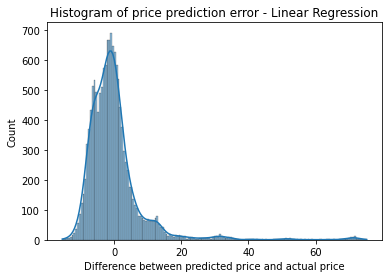

In [ ]:
# Difference between predicted price and actual price
diff_test = test_pred - y_test
over_pct = round(sum(diff_test>0)/len(diff_test)*100, 1)
under_pct = round(sum(diff_test<0)/len(diff_test)*100, 1)

print("Percentage of over-estimation: ", over_pct,'%')
print("On average, over-estimates by: ", diff_test[diff_test>0].mean())
print("Percentage of under-estimation: ", under_pct,'%')
print("On average, under-estimates by: ", abs(diff_test[diff_test<0].mean()))

sns.histplot(diff_test, kde=True)
plt.title('Histogram of price prediction error - Linear Regression')
plt.xlabel('Difference between predicted price and actual price')
plt.show()

Interestingly enough, the variation in reviews is only explained by about 9% of these features. We won't immediately conclude that these features don't determine ratings just yet because the metric only applies to OLS. One conclusion we *can* draw though is that linear regression probably isn't the best model to use.

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.091
Model:                              OLS   Adj. R-squared:                  0.090
Method:                   Least Squares   F-statistic:                     89.77
Date:                  Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                          19:45:18   Log-Likelihood:            -1.5277e+05
No. Observations:                 42316   AIC:                         3.056e+05
Df Residuals:                     42268   BIC:                         3.061e+05
Df Model:                            47                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

*Random Forest*

Again, we see that Random Forest performs better. What's interesting though is the over- and underestimates basically follow the same breakdown as our linear regression model.

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=5)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test) 
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  4.805551504004613
Test loss:  5.074188189596606


Percentage of over-estimation:  35.8 %
On average, over-estimates by:  7.051195143756905
Percentage of under-estimation:  64.2 %
On average, under-estimates by:  3.9734266750023406


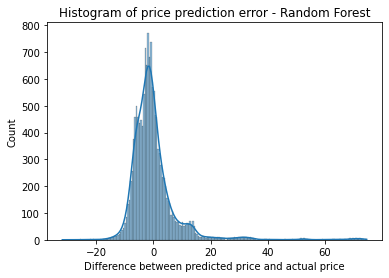

In [ ]:
# Difference between predicted price and actual price
diff_test = test_pred - y_test
over_pct = round(sum(diff_test>0)/len(diff_test)*100, 1)
under_pct = round(sum(diff_test<0)/len(diff_test)*100, 1)

print("Percentage of over-estimation: ", over_pct,'%')
print("On average, over-estimates by: ", diff_test[diff_test>0].mean())
print("Percentage of under-estimation: ", under_pct,'%')
print("On average, under-estimates by: ", abs(diff_test[diff_test<0].mean()))

sns.histplot(diff_test, kde=True)
plt.title('Histogram of price prediction error - Random Forest')
plt.xlabel('Difference between predicted price and actual price')
plt.show()

To get a better understanding of how this came about, we'll identify the top 10 most important features as determined by the model.

We see that the most important feature is actually whether or not a host is a superhost. This is closely followed by days since a host received their first review and days since they have been a host.

In [ ]:
features = np.array(X_train.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Random Forest: Features ranked by descending order of importance")
for i in range(10):
  print(features[indices[i]], ': ', importances[indices[i]])

Random Forest: Features ranked by descending order of importance
host_is_superhost :  0.10005768910765628
days_since_firstreview :  0.07415497694806925
days_since_host :  0.07369173205859945
host_listings_count :  0.06356876936896001
price :  0.05550357323340917
desc_com :  0.051141379914585575
number_of_reviews :  0.05028238167368907
host_response_rate :  0.04625751736623591
income :  0.045708945419207
host_com :  0.033480071136975285


K-Nearest Neighbors

We plotted the average error against the number of k used, and we noticed that the improvement in test performance slowed down around k = 10. The test set error was around 5.6 if we were to choose an optimal k using the elbow method. This is slightly worse than random forest performance. 


In [ ]:
train_loss = []
test_loss = []
for k in np.arange(1,31):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, y_train)
  train_pred = knn.predict(X_train)
  test_pred = knn.predict(X_test) 
  test_loss.append(mean_absolute_error(y_test, test_pred))
  print('K: ',k)
  print("Training loss: ", mean_absolute_error(y_train, train_pred))
  print("Test loss: ", mean_absolute_error(y_test, test_pred))

K:  1
Training loss:  0.0004726344645051517
Test loss:  6.888416276761662
K:  2
Training loss:  3.4729534927686925
Test loss:  6.252233092301148
K:  3
Training loss:  4.263462204997322
Test loss:  6.101918805236542
K:  4
Training loss:  4.608298279610549
Test loss:  5.985272224585283
K:  5
Training loss:  4.794437092352775
Test loss:  5.906777257904438
K:  6
Training loss:  4.927966568988877
Test loss:  5.831419254218063
K:  7
Training loss:  5.01955356298867
Test loss:  5.778493447570437
K:  8
Training loss:  5.09569666320068
Test loss:  5.739366227137388
K:  9
Training loss:  5.147018201678377
Test loss:  5.717204656804827
K:  10
Training loss:  5.190611116362605
Test loss:  5.6947894512973205
K:  11
Training loss:  5.228205106170888
Test loss:  5.684924532436229
K:  12
Training loss:  5.258592100702649
Test loss:  5.6704534713360735
K:  13
Training loss:  5.27742370589048
Test loss:  5.649080042316963
K:  14
Training loss:  5.298200275478373
Test loss:  5.636608535375018
K:  15
Trai

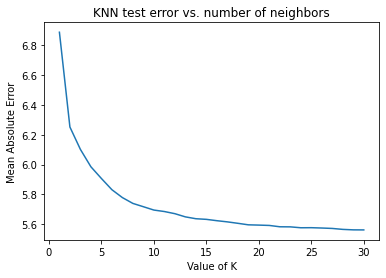

In [ ]:
plt.plot(np.arange(1,31,1), test_loss, label = 'Test Error')
plt.xlabel('Value of K')
plt.ylabel('Mean Absolute Error')
plt.title('KNN test error vs. number of neighbors')
plt.show()

*Neural Network*

Finally, as before, we tried to train and test using a neural network, but the test set result is worse than all the simple models we ran on the same dataset. This shows that using more complex model is not a guarantee for better performance. 

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F 
import torch.utils.data as data

X_train_nn = torch.from_numpy(X_t.to_numpy()) 
X_val_nn = torch.from_numpy(X_val.to_numpy())
y_train_nn = torch.from_numpy(y_t.to_numpy().reshape(len(y_t),1))
y_val_nn = torch.from_numpy(y_val.to_numpy().reshape(len(y_val),1))

train_data = data.TensorDataset(X_train_nn, y_train_nn)
trainloader = data.DataLoader(train_data, batch_size = 256, shuffle=True)

val_data = data.TensorDataset(X_val_nn, y_val_nn)

In [ ]:
class Net(nn.Module):
  
  def __init__(self, n_features, hidden_size):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(n_features, hidden_size)
    self.hidden = nn.Linear(hidden_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.hidden(x))
    x = self.linear2(x)
    
    return x

In [ ]:
net = Net(X_train.shape[1], hidden_size = 15)

criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

training_loss = []
validation_loss = []

for epoch in range(30):

  train_loss = []

  for batch in trainloader:

    optimizer.zero_grad()

    y_pred = net(batch[0].float())
    loss = criterion(y_pred, batch[1].float())
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  net.eval()
  print("Epoch", epoch)
  print("training loss: ", np.mean(train_loss))
  training_loss.append(np.mean(train_loss))
  y_val_pred = net(X_val_nn.float())
  val_loss = criterion(y_val_pred, y_val_nn.float())
  print("validation loss: ", val_loss.item())
  validation_loss.append(val_loss.item())

Epoch 0
training loss:  40.578953296907486
validation loss:  30.244373321533203
Epoch 1
training loss:  29.762045537271806
validation loss:  28.896005630493164
Epoch 2
training loss:  27.774263428103538
validation loss:  25.83808708190918
Epoch 3
training loss:  23.56010107840261
validation loss:  20.40203285217285
Epoch 4
training loss:  17.260187133666008
validation loss:  14.562180519104004
Epoch 5
training loss:  13.496255713124429
validation loss:  12.63418197631836
Epoch 6
training loss:  12.284768027644004
validation loss:  11.614092826843262
Epoch 7
training loss:  11.140572955531459
validation loss:  10.845203399658203
Epoch 8
training loss:  10.288586147369877
validation loss:  10.134520530700684
Epoch 9
training loss:  9.583131767088368
validation loss:  9.171038627624512
Epoch 10
training loss:  8.992924005754533
validation loss:  8.598034858703613
Epoch 11
training loss:  8.688576175320533
validation loss:  8.294852256774902
Epoch 12
training loss:  8.484206511128333
valid

In [ ]:
X_test_nn = torch.from_numpy(X_test.to_numpy()) 
y_test_nn = torch.from_numpy(y_test.to_numpy().reshape(len(y_test),1)) 
y_train_pred = net(X_test_nn.float())
print("test loss: ", criterion(y_train_pred, y_test_nn).item())

test loss:  6.228086143795453


### Sensitivity Analysis

Above, we saw that the biggest determinants are features relating to how established a host is: if they are a superhost, if they have been a host for a while, if they have many properties, and the such.

Now, we'll explore and see what the impacts of sentiment features are, if any. Since Random Forest performed the best, we will continue to use this model in our experiments.

#### Gender of Host Names

We saw that gender and commonality have almost no impact on our models. Let's take a closer look. Our focus for this section will be on just the sentiment features.

In [ ]:
X_train_name = X_train[['nh_com','desc_com','host_com','gender','isCommon']]
X_test_name = X_test[['nh_com','desc_com','host_com','gender','isCommon']]

As we can see, the loss increased, but this is expected because as we saw from above that other features seem to be more important.

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=5)
rf.fit(X_train_name, y_train)
train_pred = rf.predict(X_train_name)
test_pred = rf.predict(X_test_name) 
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  5.33623983641231
Test loss:  5.537314466070928


What's really telling though is the breakdown of importance of each sentiment feature. It seems that a description is the most important by a huge margin, whereas gender and commonality of a name still have almost no impact.

In [ ]:
features = np.array(X_train_name.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Random Forest: Features ranked by descending order of importance")
for i in range(len(indices)):
  print(features[indices[i]], ': ', importances[indices[i]])

Random Forest: Features ranked by descending order of importance
desc_com :  0.44518574230681685
host_com :  0.2620829798250675
nh_com :  0.23216859195909506
gender :  0.04219095229366416
isCommon :  0.0183717336153562


To ensure our conclusion, let's remove some noise from our dataset by removing any listings that do not have an identified gender. Looking at the breakdown, we can see that removing those with no tagged gender might actually reduce our loss.

In [ ]:
listings_review_df.groupby('gender')[['nh_com','desc_com','host_com','isCommon']].mean()

,nh_com,desc_com,host_com,isCommon
gender,,,,
-1,0.180303,0.304534,0.238015,0.000000
0,0.201400,0.308225,0.250550,0.966366
1,0.210567,0.309378,0.261023,0.875513


In [ ]:
listings_gender_df = listings_review_df[listings_review_df.gender != -1]

Now let's see what we get.

In [ ]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(listings_gender_df.drop(columns='review_scores_rating'), listings_gender_df['review_scores_rating'], random_state=47)

In [ ]:
X_train_g = X_train_g[['nh_com','desc_com','host_com','gender','isCommon']]
X_test_g = X_test_g[['nh_com','desc_com','host_com','gender','isCommon']]

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=5)
rf.fit(X_train_g, y_train_g)
train_pred = rf.predict(X_train_g)
test_pred = rf.predict(X_test_g) 
print("Training loss: ", mean_absolute_error(y_train_g, train_pred))
print("Test loss: ", mean_absolute_error(y_test_g, test_pred))

Training loss:  5.087385945122339
Test loss:  5.319747585563989


Our loss did decrease, but again, the descriptive features are more important than gender and commonality. This is great! We can generally conclude that implicit biases really have little to no impact on how a guest reviews their host.

In [ ]:
features = np.array(X_train_g.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Random Forest: Features ranked by descending order of importance")
for i in range(len(indices)):
  print(features[indices[i]], ': ', importances[indices[i]])

Random Forest: Features ranked by descending order of importance
desc_com :  0.4623853223342356
host_com :  0.24469609439191725
nh_com :  0.2414988829470478
gender :  0.03251329347543607
isCommon :  0.018906406851363328


#### Listings with Completed Descriptions

Now let's pivot and analyze the sentiment scores of "host_about", "description" and "neighborhood_overview" a little more closely. We saw that these three do impact ratings, so let's see what the effect is if we narrow our scope to include just listings that have all three completed.

In [ ]:
listings_sent_df = listings_review_df[listings_review_df.nh_com != 0]
listings_sent_df = listings_sent_df[listings_sent_df.host_com != 0]
listings_sent_df = listings_sent_df[listings_sent_df.desc_com != 0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(listings_sent_df.drop(columns='review_scores_rating'), listings_sent_df['review_scores_rating'], random_state=47)

By narrowing our scope, we can see that the loss improved by over a point.

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=5)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test) 
print("Training loss: ", mean_absolute_error(y_train, train_pred))
print("Test loss: ", mean_absolute_error(y_test, test_pred))

Training loss:  3.4109441376232215
Test loss:  3.864556085782461


What are the implications? We can still see that the top 3 most important features still largely dictate ratings. However, now it seems that positive descriptions are also extremely important, whereas neighborhood overviews and host "about"s are less so (though still in the top 10). 

In [ ]:
features = np.array(X_train.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Random Forest: Features ranked by descending order of importance")
for i in range(10):
  print(features[indices[i]], ': ', importances[indices[i]])

Random Forest: Features ranked by descending order of importance
host_is_superhost :  0.0849275605412808
host_listings_count :  0.07823518861121787
days_since_firstreview :  0.07618726274588013
desc_com :  0.06184775149990178
days_since_host :  0.06136480514754574
price :  0.057404726506466816
number_of_reviews :  0.04959463058629625
nh_com :  0.04826653825944446
income :  0.04536472457842741
host_com :  0.039333732953512876


### Conclusion: Reviews Prediction

Analyzing qualitative factors is always a big challenge, and we see that with this analysis. However, there are a number of things that we can generally conclude.

Gender and commonality of a name had little to no impact on how ratings. This means that stereotypes and biases don't change a guest's perspective on how to rate a listing overall. This is great news because these really shouldn't!

On the other hand, descriptions did. Our analysis does not measure causation, but there was certainly a correlation between higher-rated Airbnbs and descriptions. Most important was the description about the listing; descriptions about the hosts themselves (host_about) or the neighborhood (neighborhood_overview) had some impact, but not as much. This also makes sense since guests should really be reviewing the Airbnb itself and not the factors unrelated to a host.

Despite all these, the best thing a host can do is establish themselves as a fantastic host. Guests generally trust external measures more, which are factors that hosts can't directly control. Achieving superhost status is major because Airbnb reviews and decides who deserves this status by vetting each Airbnb at least four times a year. Number of reviews is also a solid factor because the higher it is, the higher the number of people who have reviewed the listing is, which means that guests can make a more informed decision on whether or not to book a listing based on past experiences of others. 

**Final Conclusion**: Hosts should spend some time to flesh out a positive description about their listing. If they can, they should also do the same and talk positively about the neighborhood and also about themselves. Doing this (along with actually maintaining a great Airbnb) might help them establish themselves which will help them reap the greatest benefits. However, this is just our speculation; we did not analyze whether relationships are causal, just that they are correlated. 


# Overall Conclusion

What conclusions can we draw from this analysis? Here are a few big ones:
* Airbnbs are different between NYC and LA regardless of the fact they are both big and diverse. More specifically, Airbnbs in LA are generally rated higher than those in NYC.
* Price is difficult to accurately predict because there are so many factors, both internal and external, that impact it. The analysis was even more complicated because our assumption is that Airbnbs are reasonably priced, but ultimately, they are subject to the discretion of the host. Regardless, we saw that:
  * Income and crime were valuable factors in predicting price. Removing these two features dramatically increased the loss.
  * The more bedrooms a listing had, the more difficult it was to predict the price. The prices of listings with 4 or more bedrooms were widely varied, making it difficult for our models to determine how to price them.
* Ratings were also difficult to predict given our data. From our analysis, we could conclude the following:
  * People are generally kind! The impact of implicit biases that may come with a host's name or gender had very minimal impact on ratings.
  * External sources that vouch for a host are more important than what hosts personally say. If a host is a superhost or have a long history of being a good host, their ratings tend to be higher. Again, we can only comment on the correlation between the two; we *cannot* comment on whether the relationship is causal.

The final, most obvious conclusion is that if we had more data, we could draw better conclusions and make better predictions. For instance, if we had individual ratings given by individual guests for a given listing, we might be able to better predict ratings [1]. Even if we could interview some hosts and get a picture of their thought process, we could interpret and analyze this data better.

All in all, this analysis proved to be a good first step in understanding the dynamics of Airbnbs in NYC and LA. It provided an overarching glimpse at what we might discover about Airbnbs and we hope that the outcomes can be leveraged for more intricate and deeper analyses in the future.

We hope you enjoyed your stay!

[1] We did find data containing reviews related to a given listing from individual guests, but it did not contain the corresponding rating.